Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 11 - Asset allocation in Python

## 11.1 Evaluating an equally-weighted portfolio's performance

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import quantstats as qs

2. Define the considered assets and download their prices from Yahoo Finance:

[*********************100%***********************]  5 of 5 completed


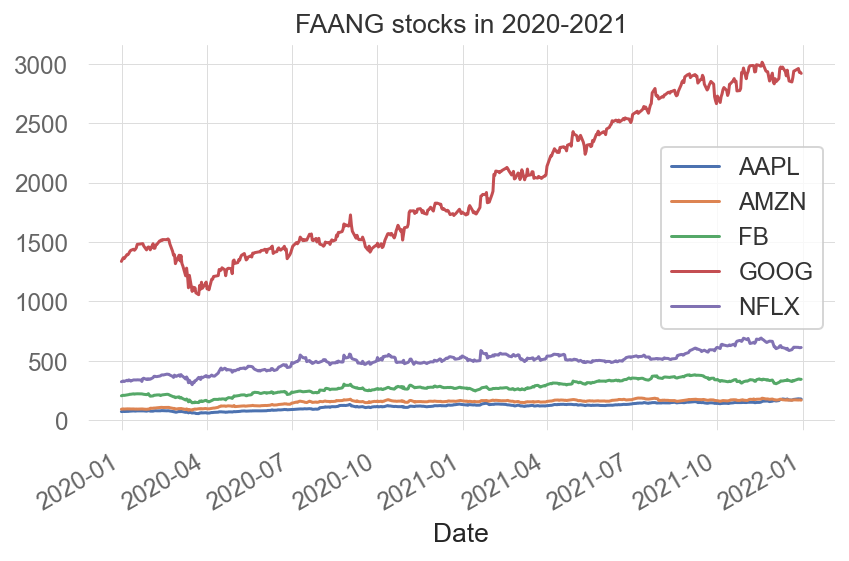

In [5]:
ASSETS = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]
n_assets = len(ASSETS)

prices_df = yf.download(ASSETS, 
                        start="2020-01-01", 
                        end="2021-12-31", 
                        adjusted=True)
prices_df["Adj Close"].plot(title="FAANG stocks in 2020-2021")

sns.despine()
plt.tight_layout()


3. Calculate individual asset returns:

In [6]:
returns = prices_df["Adj Close"].pct_change().dropna()

4. Define the weights:

In [7]:
portfolio_weights = n_assets * [1 / n_assets]

5. Calculate portfolio returns:

In [8]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), 
                              index=returns.index)

6. Generate basic performance evaluation plots:

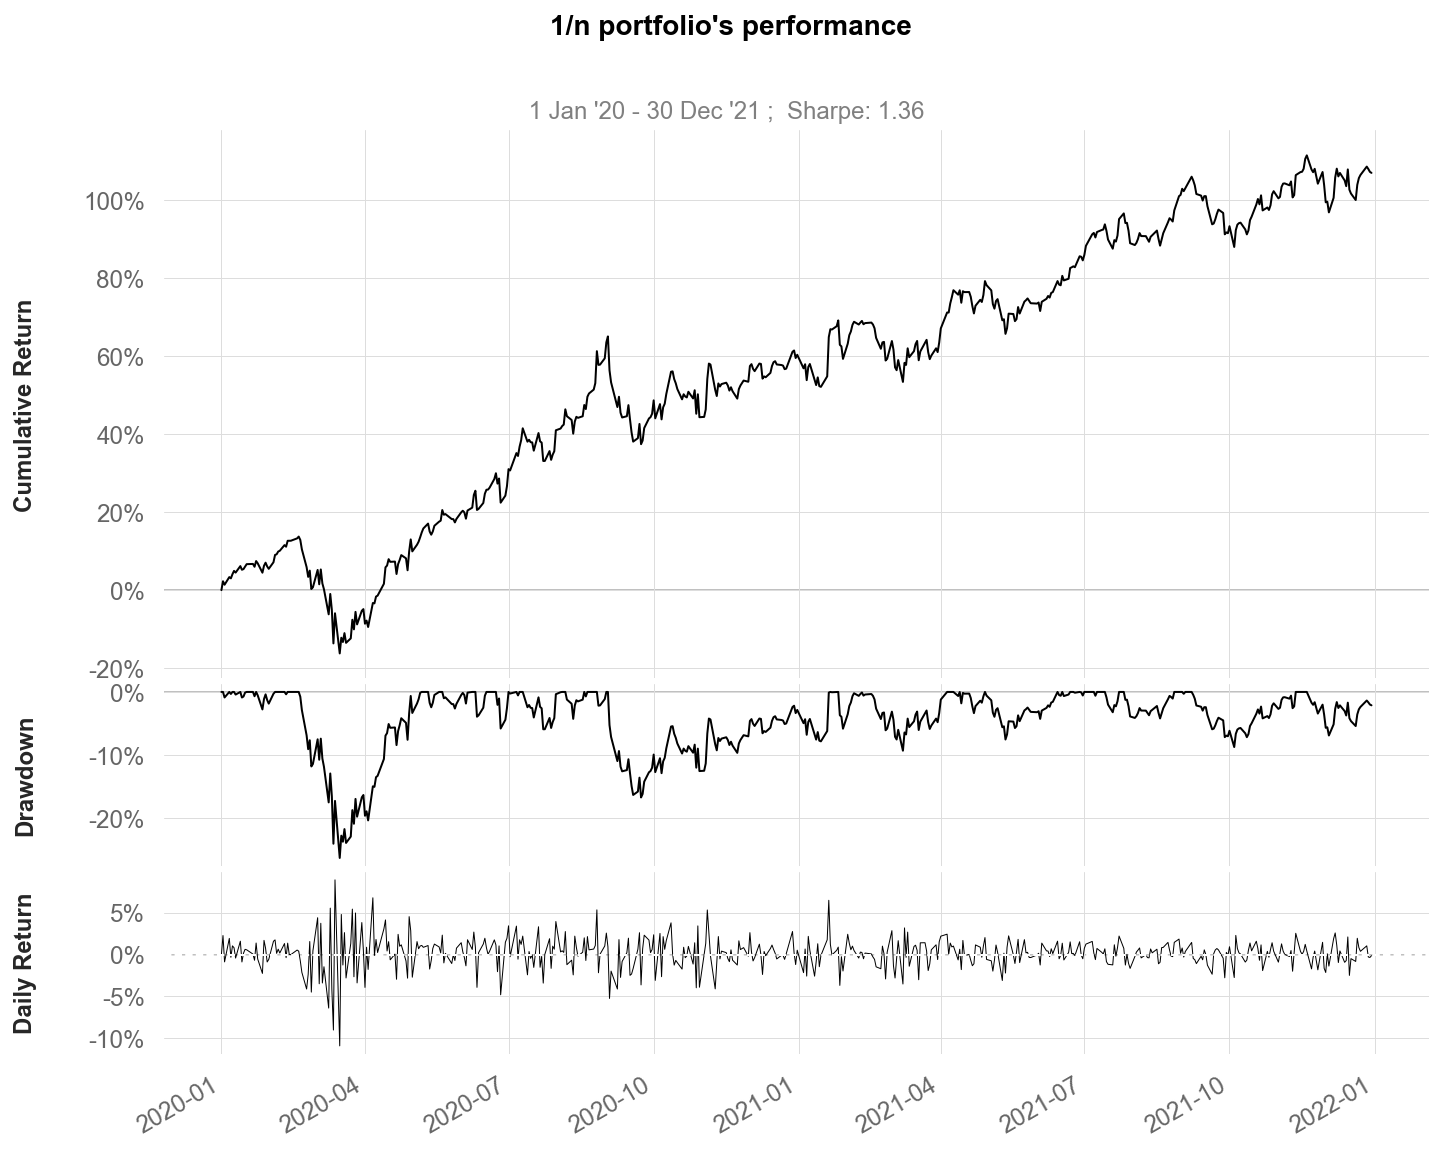

In [9]:
qs.plots.snapshot(portfolio_returns, 
                  title="1/n portfolio's performance", 
                  grayscale=True)

7. Calculate the basic portfolio evaluation metrics:

In [10]:
qs.reports.metrics(portfolio_returns, 
                   benchmark="SPY", 
                   mode="basic")

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-01-02  2020-01-02
End Period          2021-12-30  2021-12-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   107.0%      51.3%
CAGR﹪              44.02%      23.07%

Sharpe              1.36        0.94
Sortino             1.96        1.3
Sortino/√2          1.39        0.92
Omega               1.28        1.28

Max Drawdown        -26.35%     -33.72%
Longest DD Days     140         172

Gain/Pain Ratio     0.28        0.22
Gain/Pain (1M)      3.48        1.54

Payoff Ratio        0.84        0.8
Profit Factor       1.28        1.22
Common Sense Ratio  1.21        0.97
CPC Index           0.63        0.57
Tail Ratio          0.94        0.8
Outlier Win Ratio   4.13        5.68
Outlier Loss Ratio  3.3         4.46

MTD                 1.56%       4.89%
3M                  8.24%       10.17%
6M                  11.59%      12.08%


### There's more

1. Generate the full HTML tear sheet:

In [20]:
qs.reports.html(portfolio_returns, 
                benchmark="SPY", 
                title="1/n portfolio",
                download_filename="EW portfolio evaluation.html")

2. Add the methods of `quantstats` to the `pandas` DataFrame:

In [12]:
qs.extend_pandas()

3. Calculate the Sharpe ratio and the Sortino ratio using the newly added methods:

In [13]:
print(f"Sharpe ratio: {portfolio_returns.sharpe():.2f}")
print(f"Sortino ratio: {portfolio_returns.sortino():.2f}")

Sharpe ratio: 1.36
Sortino ratio: 1.96


4. See all the new methods that are available to us thanks to the `quantstats` library:

In [14]:
[method for method in dir(qs.stats) if method[0] != "_"]

['adjusted_sortino',
 'autocorr_penalty',
 'avg_loss',
 'avg_return',
 'avg_win',
 'best',
 'cagr',
 'calmar',
 'common_sense_ratio',
 'comp',
 'compare',
 'compsum',
 'conditional_value_at_risk',
 'consecutive_losses',
 'consecutive_wins',
 'cpc_index',
 'cvar',
 'distribution',
 'drawdown_details',
 'expected_return',
 'expected_shortfall',
 'exposure',
 'gain_to_pain_ratio',
 'geometric_mean',
 'ghpr',
 'greeks',
 'implied_volatility',
 'information_ratio',
 'kelly_criterion',
 'kurtosis',
 'max_drawdown',
 'monthly_returns',
 'omega',
 'outlier_loss_ratio',
 'outlier_win_ratio',
 'outliers',
 'payoff_ratio',
 'pct_rank',
 'profit_factor',
 'profit_ratio',
 'r2',
 'r_squared',
 'rar',
 'recovery_factor',
 'remove_outliers',
 'risk_of_ruin',
 'risk_return_ratio',
 'rolling_greeks',
 'rolling_sharpe',
 'rolling_sortino',
 'rolling_volatility',
 'ror',
 'serenity_index',
 'sharpe',
 'skew',
 'smart_sharpe',
 'smart_sortino',
 'sortino',
 'tail_ratio',
 'to_drawdown_series',
 'ulcer_ind

5. Generate the plots:

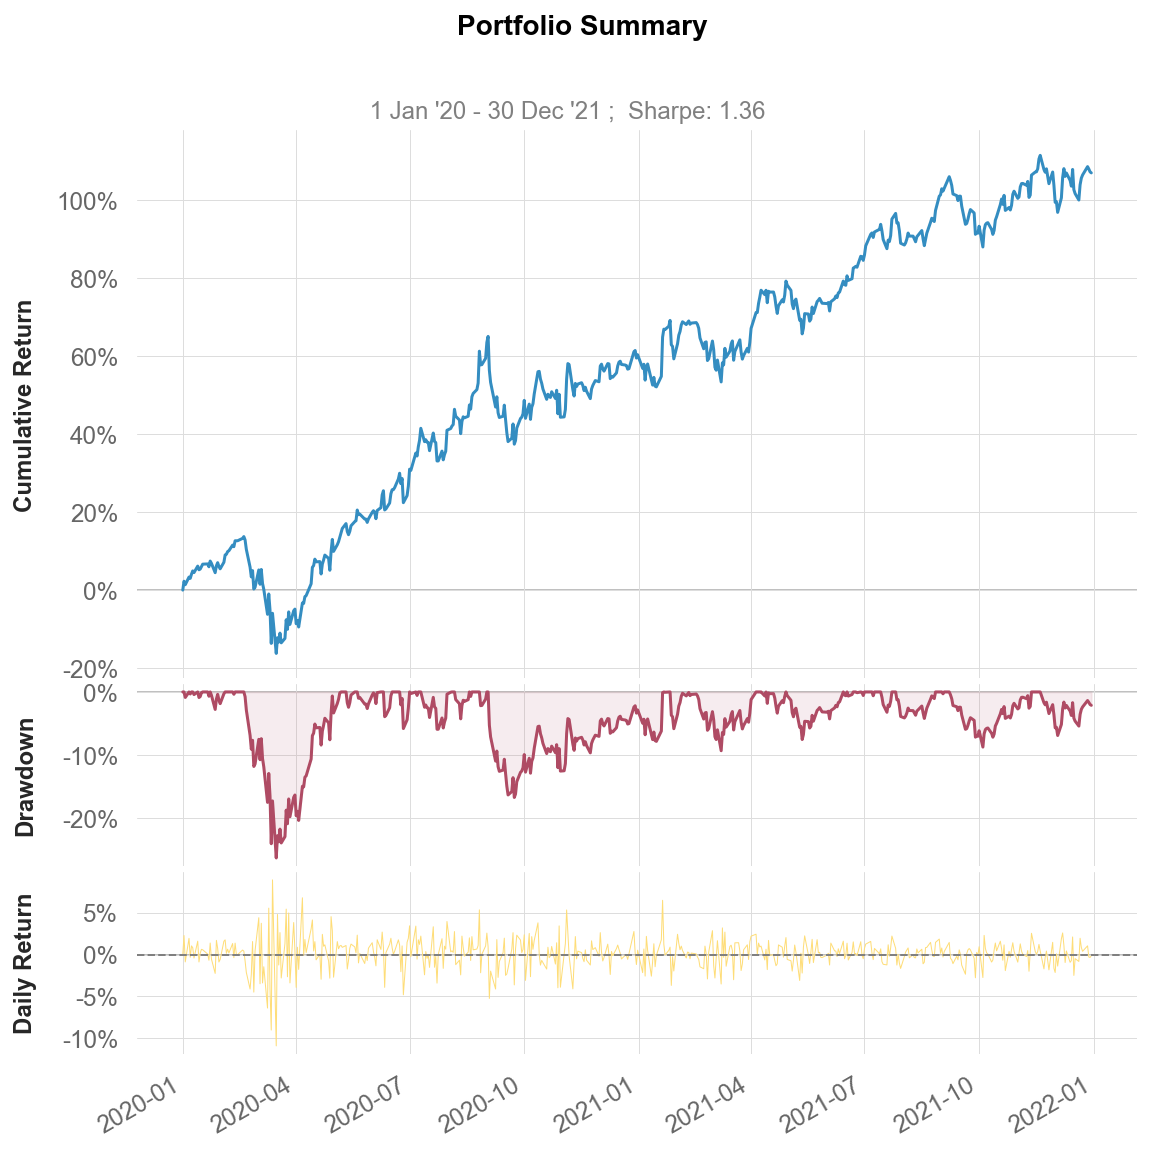

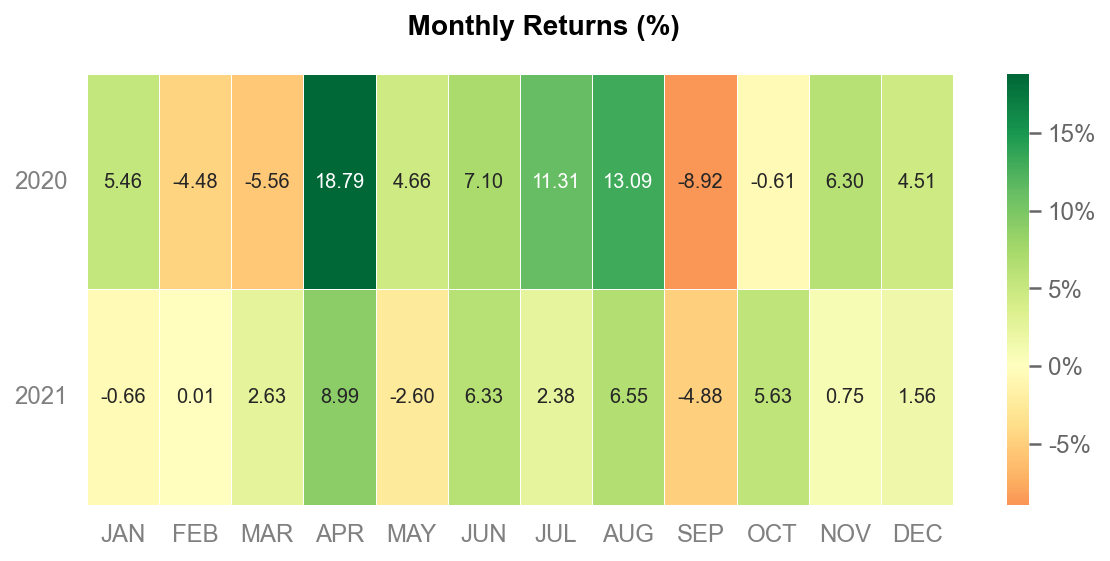

In [15]:
qs.reports.plots(portfolio_returns, benchmark="SPY", mode="basic", prepare_returns=False)
# qs.reports.plots(portfolio_returns, benchmark="SPY", mode="full", prepare_returns=False)

In [16]:
help(portfolio_returns.value_at_risk)

Help on method value_at_risk in module quantstats.stats:

value_at_risk(sigma=1, confidence=0.95, prepare_returns=True) method of pandas.core.series.Series instance
    Calculats the daily value-at-risk
    (variance-covariance calculation with confidence n)



## 11.2 Finding the efficient frontier using Monte Carlo simulations

### How to do it...

1. Import the libraries:

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd

2. Set up the parameters:

In [4]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
ASSETS = ["FB", "TSLA", "TWTR", "MSFT"]
ASSETS.sort()

n_assets = len(ASSETS)

3. Download the stock prices from Yahoo Finance:

In [5]:
prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31", 
                        adjusted=True)

[*********************100%***********************]  4 of 4 completed


In [6]:
prices_df.head()

Adj Close                                          Close  \
                    FB        MSFT        TSLA       TWTR          FB   
Date                                                                    
2020-12-31  273.160004  220.115967  705.669983  54.150002  273.160004   
2021-01-04  268.940002  215.434952  729.770020  54.529999  268.940002   
2021-01-05  270.970001  215.642776  735.109985  53.880001  270.970001   
2021-01-06  263.309998  210.051315  755.979980  53.259998  263.309998   
2021-01-07  268.739990  216.028732  816.039978  52.330002  268.739990   

                                                     High              ...  \
                  MSFT        TSLA       TWTR          FB        MSFT  ...   
Date                                                                   ...   
2020-12-31  222.419998  705.669983  54.150002  277.089996  223.000000  ...   
2021-01-04  217.690002  729.770020  54.529999  275.000000  223.000000  ...   
2021-01-05  217.899994  735.109985  53.880001  272.399994  218.520004  ...   
2021-01-06  212.250000  755.979980  53.259998  267.750000  216.490005  ...   
2021-01-07  218.289993  816.039978  52.330002  271.609985  219.339996  ...   

                   Low                   Open                          \
                  TSLA       TWTR          FB        MSFT        TSLA   
Date                                                                    
2020-12-31  691.119995  53.740002  272.000000  221.699997  699.989990   
2021-01-04  717.190002  53.580002  274.779999  222.529999  719.460022   
2021-01-05  719.200012  53.150002  268.290009  217.259995  723.659973   
2021-01-06  749.099976  52.570000  262.000000  212.169998  758.489990   
2021-01-07  775.200012  51.459999  265.899994  214.039993  777.630005   

                         Volume                                
                 TWTR        FB      MSFT      TSLA      TWTR  
Date                                                           
2020-12-31  54.240002  12900400  20942100  49649900   4832300  
2021-01-04  54.490002  15106100  37130100  48638200  12231600  
2021-01-05  53.410000   9871600  23823000  32245200   8317200  
2021-01-06  53.270000  24354100  35930700  44700000   9260000  
2021-01-07  52.220001  15789800  27694500  51498900  18967600  

[5 rows x 24 columns]

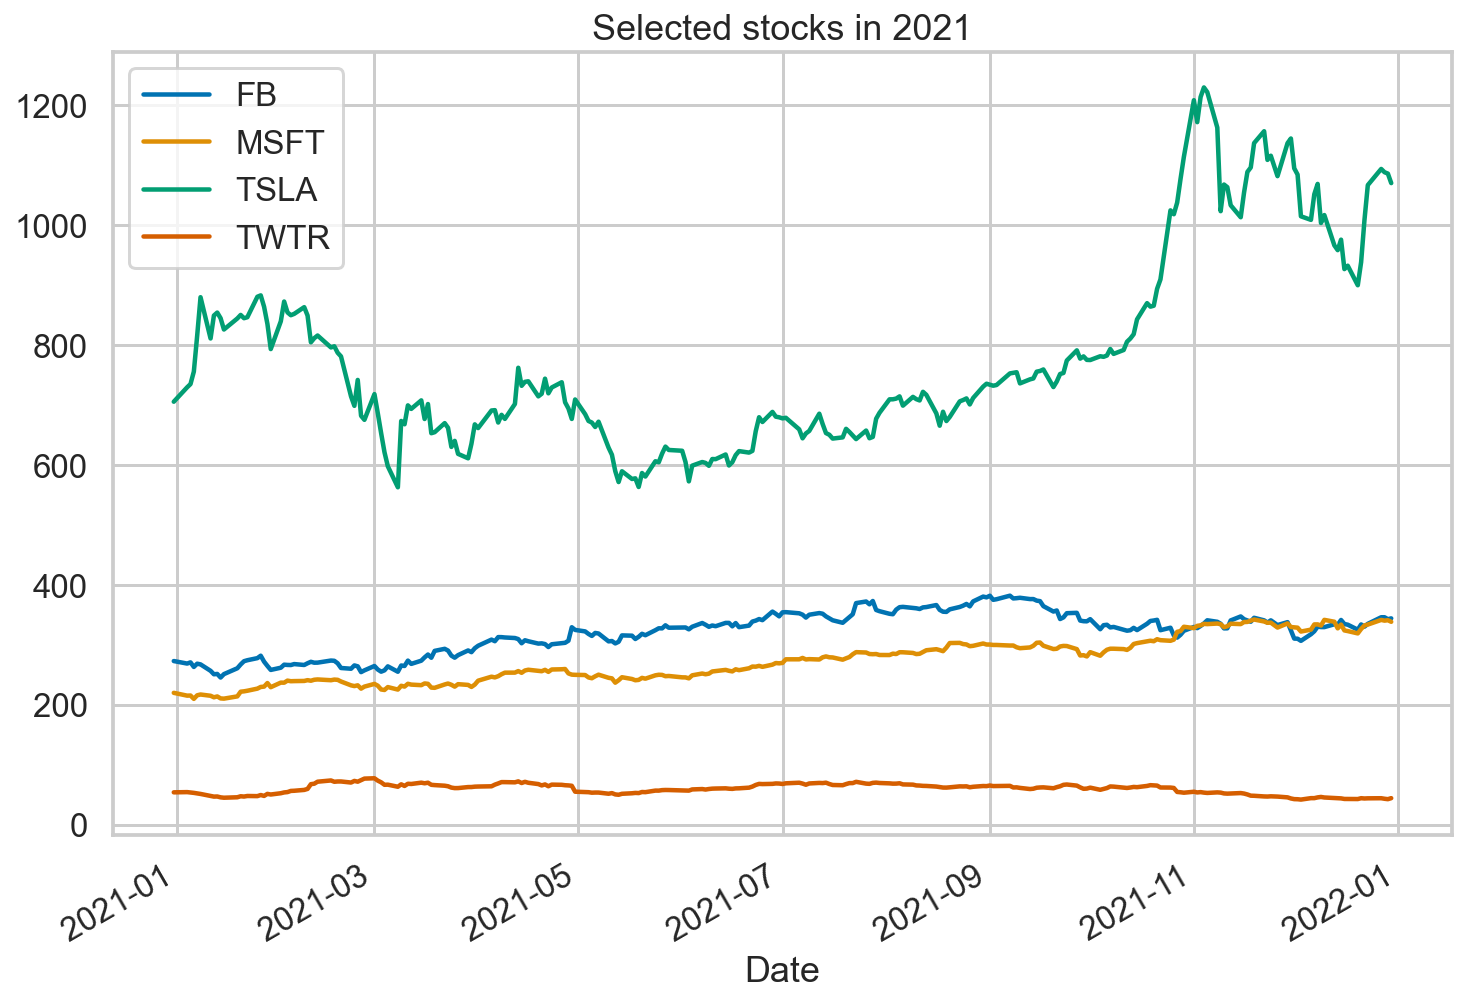

In [7]:
prices_df["Adj Close"].plot(title="Selected stocks in 2021");

4. Calculate annualized average returns and the corresponding standard deviation:

In [8]:
returns_df = prices_df["Adj Close"].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

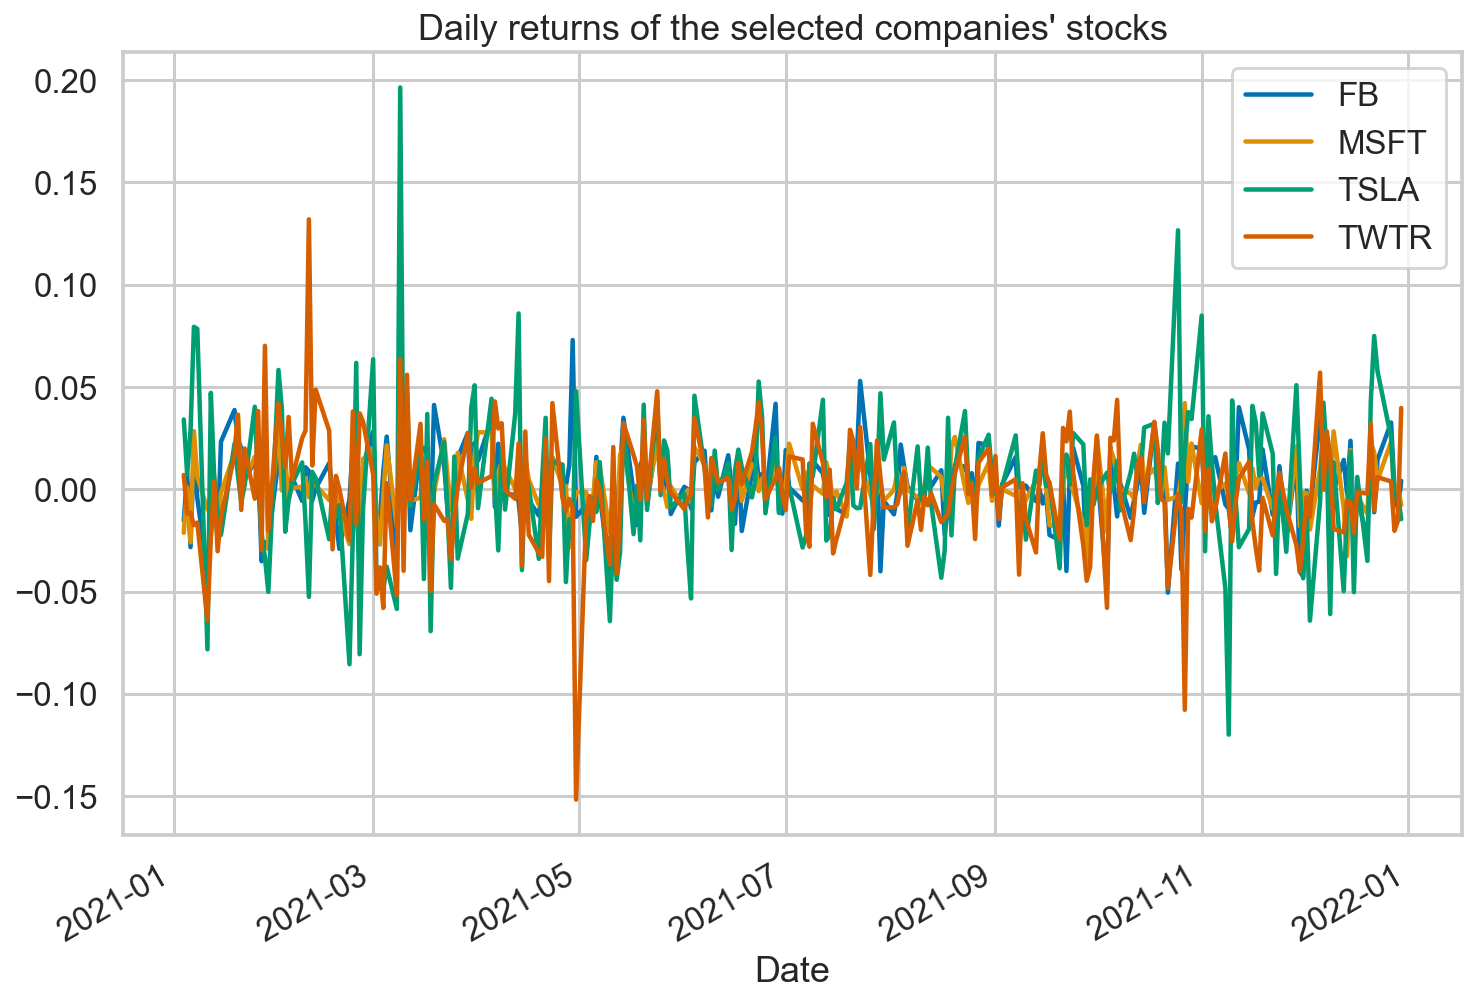

In [9]:
returns_df.plot(title="Daily returns of the selected companies' stocks");

5. Simulate random portfolio weights:

In [10]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

6. Calculate the portfolio metrics:

In [11]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    vol = np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i])))
    portf_vol.append(vol)
portf_vol = np.array(portf_vol)  

portf_sharpe_ratio = portf_rtns / portf_vol

7. Create a DataFrame containing all the data: 

In [12]:
portf_results_df = pd.DataFrame({"returns": portf_rtns,
                                 "volatility": portf_vol,
                                 "sharpe_ratio": portf_sharpe_ratio})
portf_results_df

returns  volatility  sharpe_ratio
0      0.335464    0.266351      1.259480
1      0.049227    0.346262      0.142167
2      0.175372    0.267961      0.654471
3      0.291582    0.257783      1.131114
4      0.346867    0.264669      1.310569
...         ...         ...           ...
99995  0.442953    0.279346      1.585678
99996  0.145918    0.304849      0.478655
99997  0.419965    0.278450      1.508224
99998  0.277796    0.288633      0.962455
99999  0.353457    0.305080      1.158572

[100000 rows x 3 columns]

8. Locate the points creating the Efficient Frontier:

In [13]:
N_POINTS = 100

ef_rtn_list = []
ef_vol_list = []

possible_ef_rtns = np.linspace(portf_results_df["returns"].min(), 
                               portf_results_df["returns"].max(), 
                               N_POINTS)
possible_ef_rtns = np.round(possible_ef_rtns, 2)    
portf_rtns = np.round(portf_rtns, 2)

for rtn in possible_ef_rtns:
    if rtn in portf_rtns:
        ef_rtn_list.append(rtn)
        matched_ind = np.where(portf_rtns == rtn)
        ef_vol_list.append(np.min(portf_vol[matched_ind]))

9. Plot the Efficient Frontier:

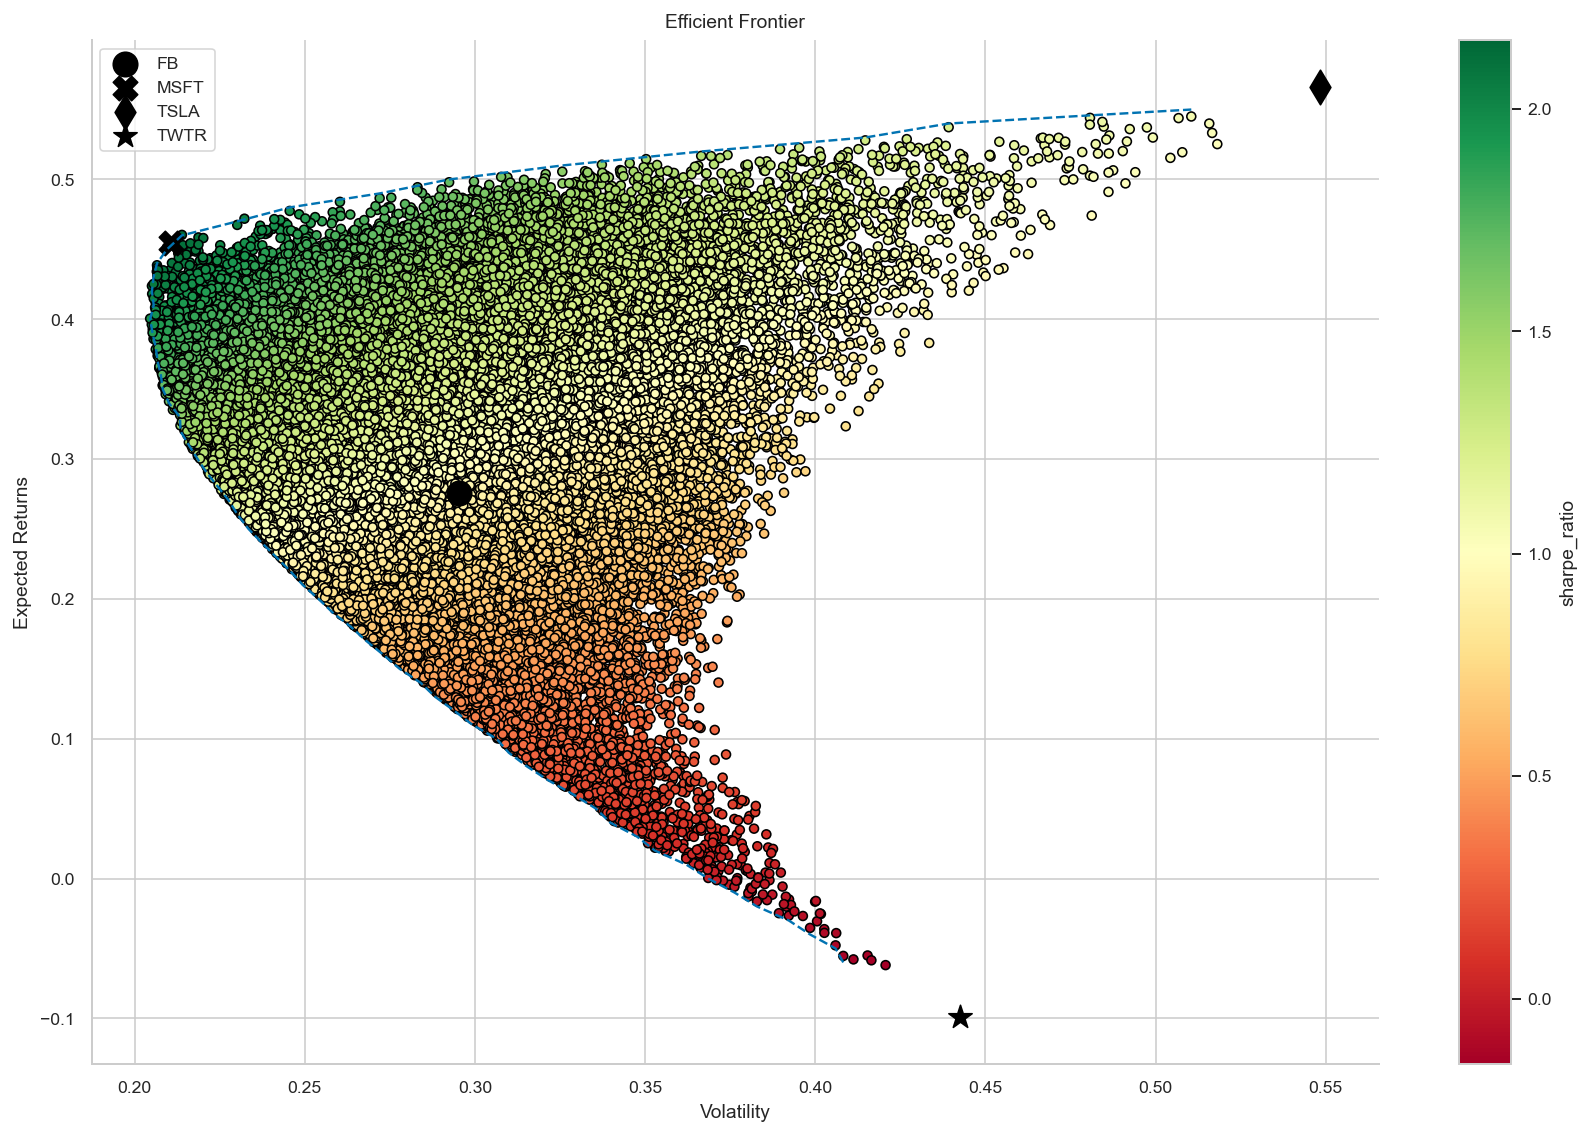

In [14]:
MARKERS = ["o", "X", "d", "*"]

with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.plot(ef_vol_list, ef_rtn_list, "b--")
    for asset_index in range(n_assets):
        ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                   y=avg_returns[asset_index], 
                   marker=MARKERS[asset_index], 
                   s=150, color="black",
                   label=ASSETS[asset_index])
    ax.legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_11_10", dpi=200)

### There's more

In [15]:
from chapter_11_utils import print_portfolio_summary

In [16]:
max_sharpe_ind = np.argmax(portf_results_df["sharpe_ratio"])
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df["volatility"])
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [17]:
print_portfolio_summary(max_sharpe_portf, 
                        weights[max_sharpe_ind], 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
returns: 45.14% volatility: 20.95% sharpe_ratio: 215.46% 
Weights
FB: 2.60% MSFT: 95.17% TSLA: 2.04% TWTR: 0.19% 

In [18]:
print_portfolio_summary(min_vol_portf, 
                        weights[min_vol_ind], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
returns: 40.05% volatility: 20.46% sharpe_ratio: 195.76% 
Weights
FB: 17.35% MSFT: 78.16% TSLA: 0.23% TWTR: 4.26% 

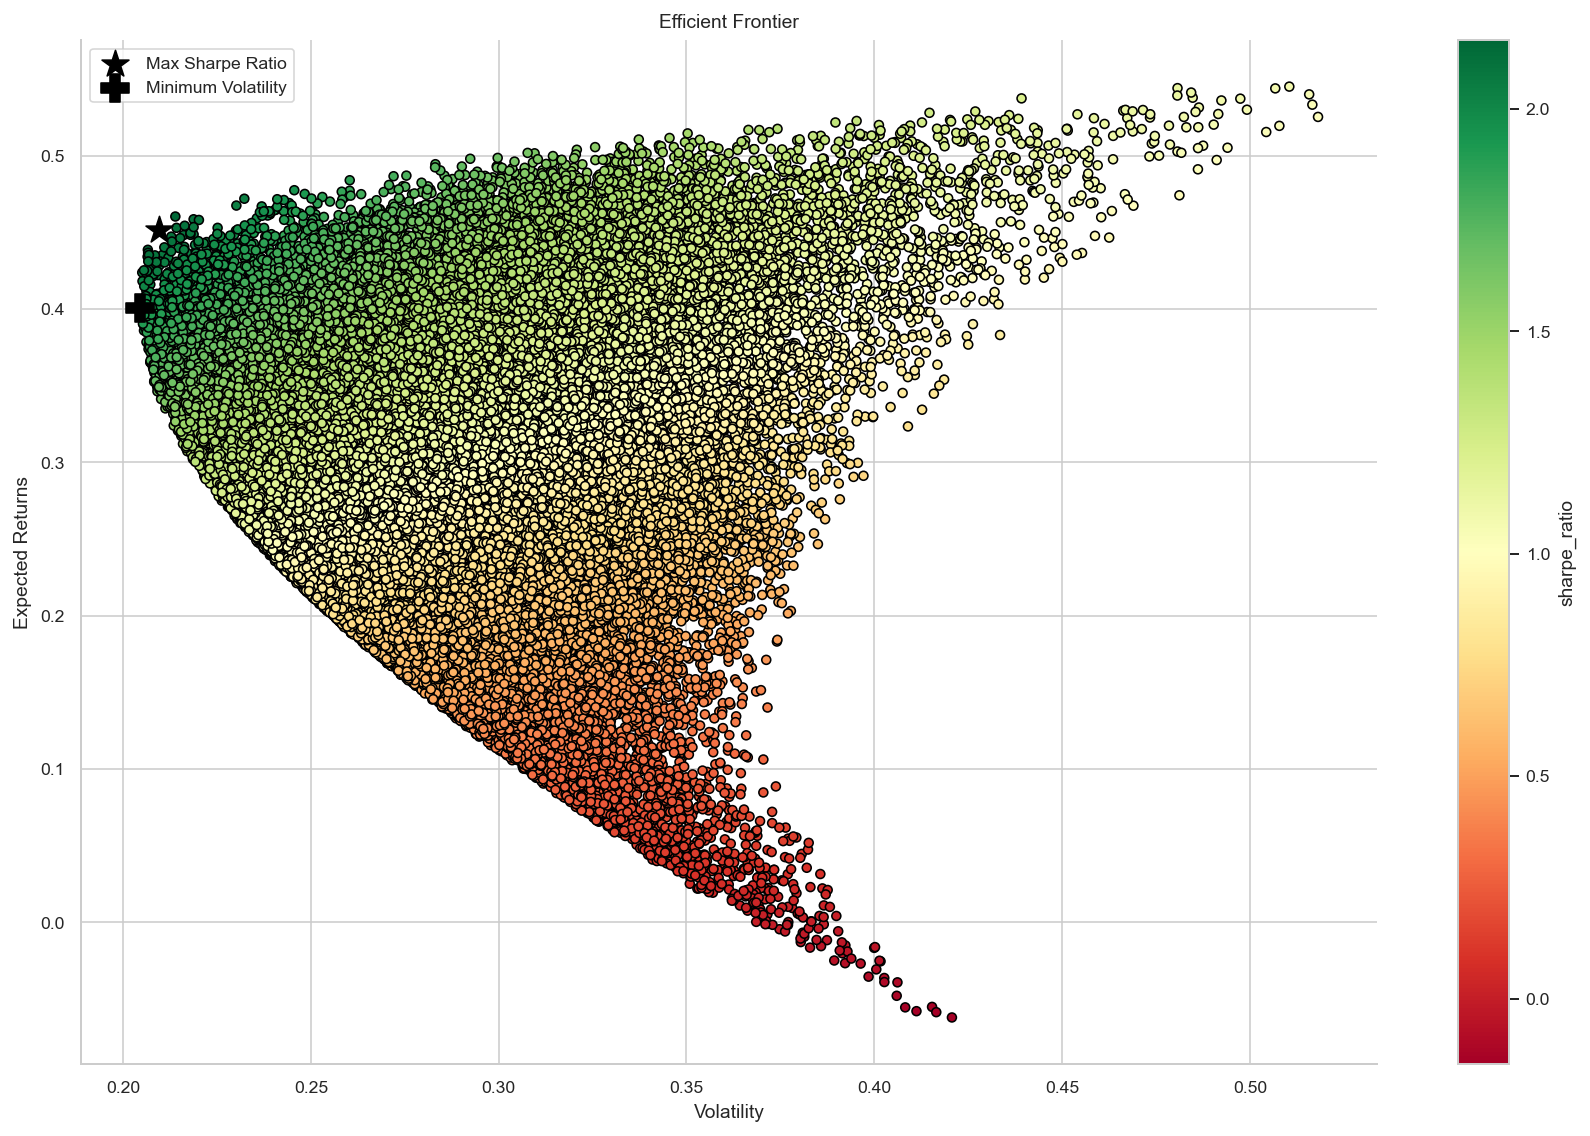

In [19]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.scatter(x=max_sharpe_portf.volatility, 
               y=max_sharpe_portf.returns, 
               c="black", marker="*", 
               s=200, label="Max Sharpe Ratio")
    ax.scatter(x=min_vol_portf.volatility, 
               y=min_vol_portf.returns, 
               c="black", marker="P", 
               s=200, label="Minimum Volatility")
    ax.set(xlabel="Volatility", ylabel="Expected Returns", 
           title="Efficient Frontier")
    ax.legend()

    sns.despine()
    plt.tight_layout()
#     plt.savefig("images/figure_11_11", dpi=200)

## 11.3 Finding the efficient frontier using optimization with `scipy`

### Getting Ready

This recipe requires running all the code from the recipe *Finding the Efficient Frontier using Monte Carlo simulations*.

### How to do it...

1. Import the libraries:

In [20]:
import numpy as np
import scipy.optimize as sco
from chapter_11_utils import print_portfolio_summary

2. Define functions calculating portfolio returns and volatility:

In [21]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

3. Define the function calculating the efficient frontier:

In [22]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constr = ({"type": "eq", 
                   "fun": lambda x: get_portf_rtn(x, avg_rtns) - ret},
                  {"type": "eq", 
                   "fun": lambda x: np.sum(x) - 1})
        ef_portf = sco.minimize(get_portf_vol, 
                                initial_guess, 
                                args=args, method="SLSQP", 
                                constraints=constr,
                                bounds=bounds)
        efficient_portfolios.append(ef_portf)
    
    return efficient_portfolios

4. Define the considered range of expected portfolio returns:

In [23]:
rtns_range = np.linspace(-0.1, 0.55, 200)

5. Calculate the Efficient Frontier:

In [24]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

6. Extract the volatilities of the efficient portfolios:

In [25]:
vols_range = [x["fun"] for x in efficient_portfolios]

7. Plot the calculated Efficient Frontier, together with the simulated portfolios:

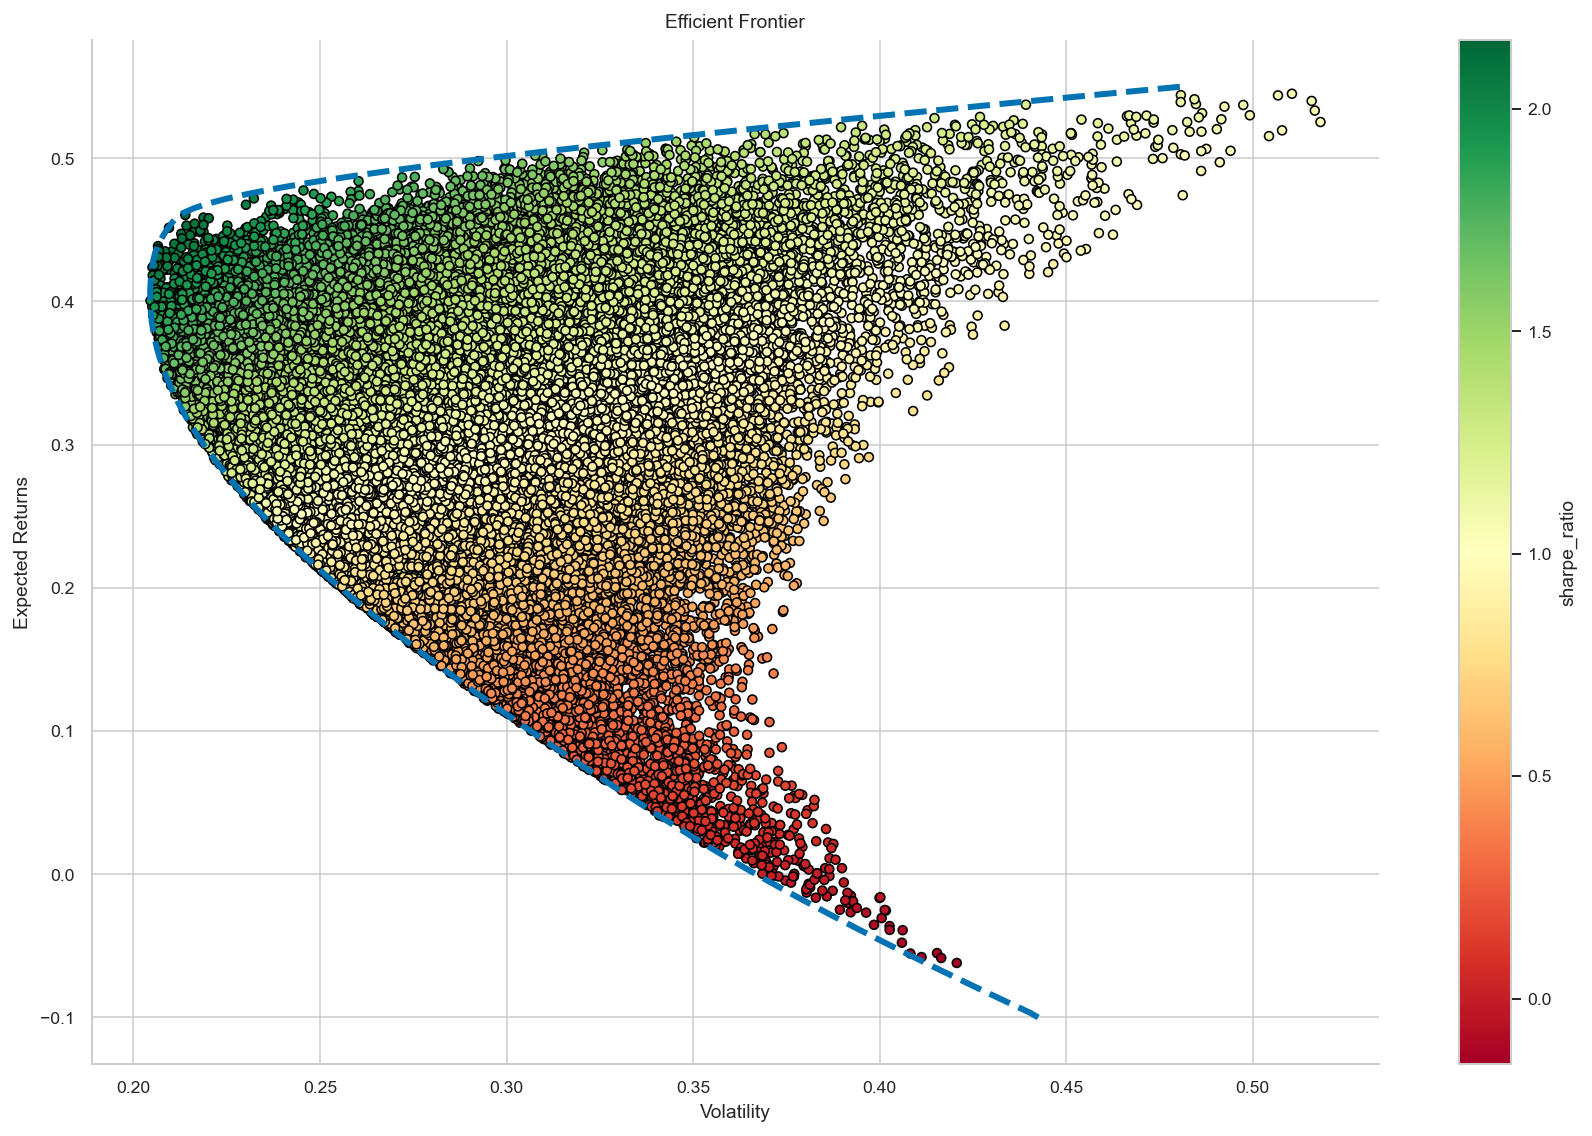

In [26]:
with sns.plotting_context("paper"):
    fig, ax = plt.subplots()
    portf_results_df.plot(kind="scatter", x="volatility", 
                          y="returns", c="sharpe_ratio",
                          cmap="RdYlGn", edgecolors="black", 
                          ax=ax)
    ax.plot(vols_range, rtns_range, "b--", linewidth=3)
    ax.set(xlabel="Volatility", 
           ylabel="Expected Returns", 
           title="Efficient Frontier")

    sns.despine()
    plt.tight_layout()
#     plt.savefig("images/figure_11_12", dpi=200)

8. Identify the minimum volatility portfolio:

In [26]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]["fun"]

min_vol_portf = {"Return": min_vol_portf_rtn,
                 "Volatility": min_vol_portf_vol,
                 "Sharpe Ratio": (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': 0.4030150753768844,
 'Volatility': 0.20447691908899487,
 'Sharpe Ratio': 1.9709563170867193}

9. Print the performance summary:

In [27]:
print_portfolio_summary(min_vol_portf, 
                        efficient_portfolios[min_vol_ind]["x"], 
                        ASSETS, 
                        name="Minimum Volatility")

Minimum Volatility portfolio ----
Performance
Return: 40.30% Volatility: 20.45% Sharpe Ratio: 197.10% 
Weights
FB: 15.98% MSFT: 79.82% TSLA: 0.00% TWTR: 4.20% 

### There's more

1. Define the new objective function (negative Sharpe ratio): 

In [28]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

2. Find the optimized portfolio:

In [29]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({"type": "eq", 
                "fun": lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method="SLSQP", 
                                bounds=bounds, 
                                constraints=constraints)

3. Extract information about the maximum Sharpe Ratio portfolio:

In [30]:
max_sharpe_portf_w = max_sharpe_portf["x"]
max_sharpe_portf = {"Return": get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    "Volatility": get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    "Sharpe Ratio": -max_sharpe_portf["fun"]}
max_sharpe_portf

{'Return': 0.4590320167096378,
 'Volatility': 0.21173007867600227,
 'Sharpe Ratio': 2.168005696592909}

4. Print performance summary:

In [31]:
print_portfolio_summary(max_sharpe_portf, 
                        max_sharpe_portf_w, 
                        ASSETS, 
                        name="Maximum Sharpe Ratio")

Maximum Sharpe Ratio portfolio ----
Performance
Return: 45.90% Volatility: 21.17% Sharpe Ratio: 216.80% 
Weights
FB: 0.00% MSFT: 96.27% TSLA: 3.73% TWTR: 0.00% 

## 11.4 Finding the efficient frontier using convex optimization with `cvxpy`

### Getting Ready

This recipe requires running all the code from the previous recipes:
* *Finding the Efficient Frontier using Monte Carlo simulations*
* *Finding the Efficient Frontier using optimization with `scipy`*

### How to do it...

1. Import the libraries:

In [27]:
import cvxpy as cp

2. Convert the annualized average returns and the covariance matrix to `numpy` arrays:

In [28]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

3. Set up the optimization problem:

In [29]:
weights = cp.Variable(n_assets)
gamma_par = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma_par * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

4. Calculate the Efficient Frontier:

In [30]:
N_POINTS = 25
portf_rtn_cvx_ef = []
portf_vol_cvx_ef = []
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for gamma in gamma_range:
    gamma_par.value = gamma
    problem.solve()
    portf_vol_cvx_ef.append(cp.sqrt(portf_vol_cvx).value)
    portf_rtn_cvx_ef.append(portf_rtn_cvx.value)
    weights_ef.append(weights.value)

5. Plot the allocation for different values of the risk-aversion parameter:

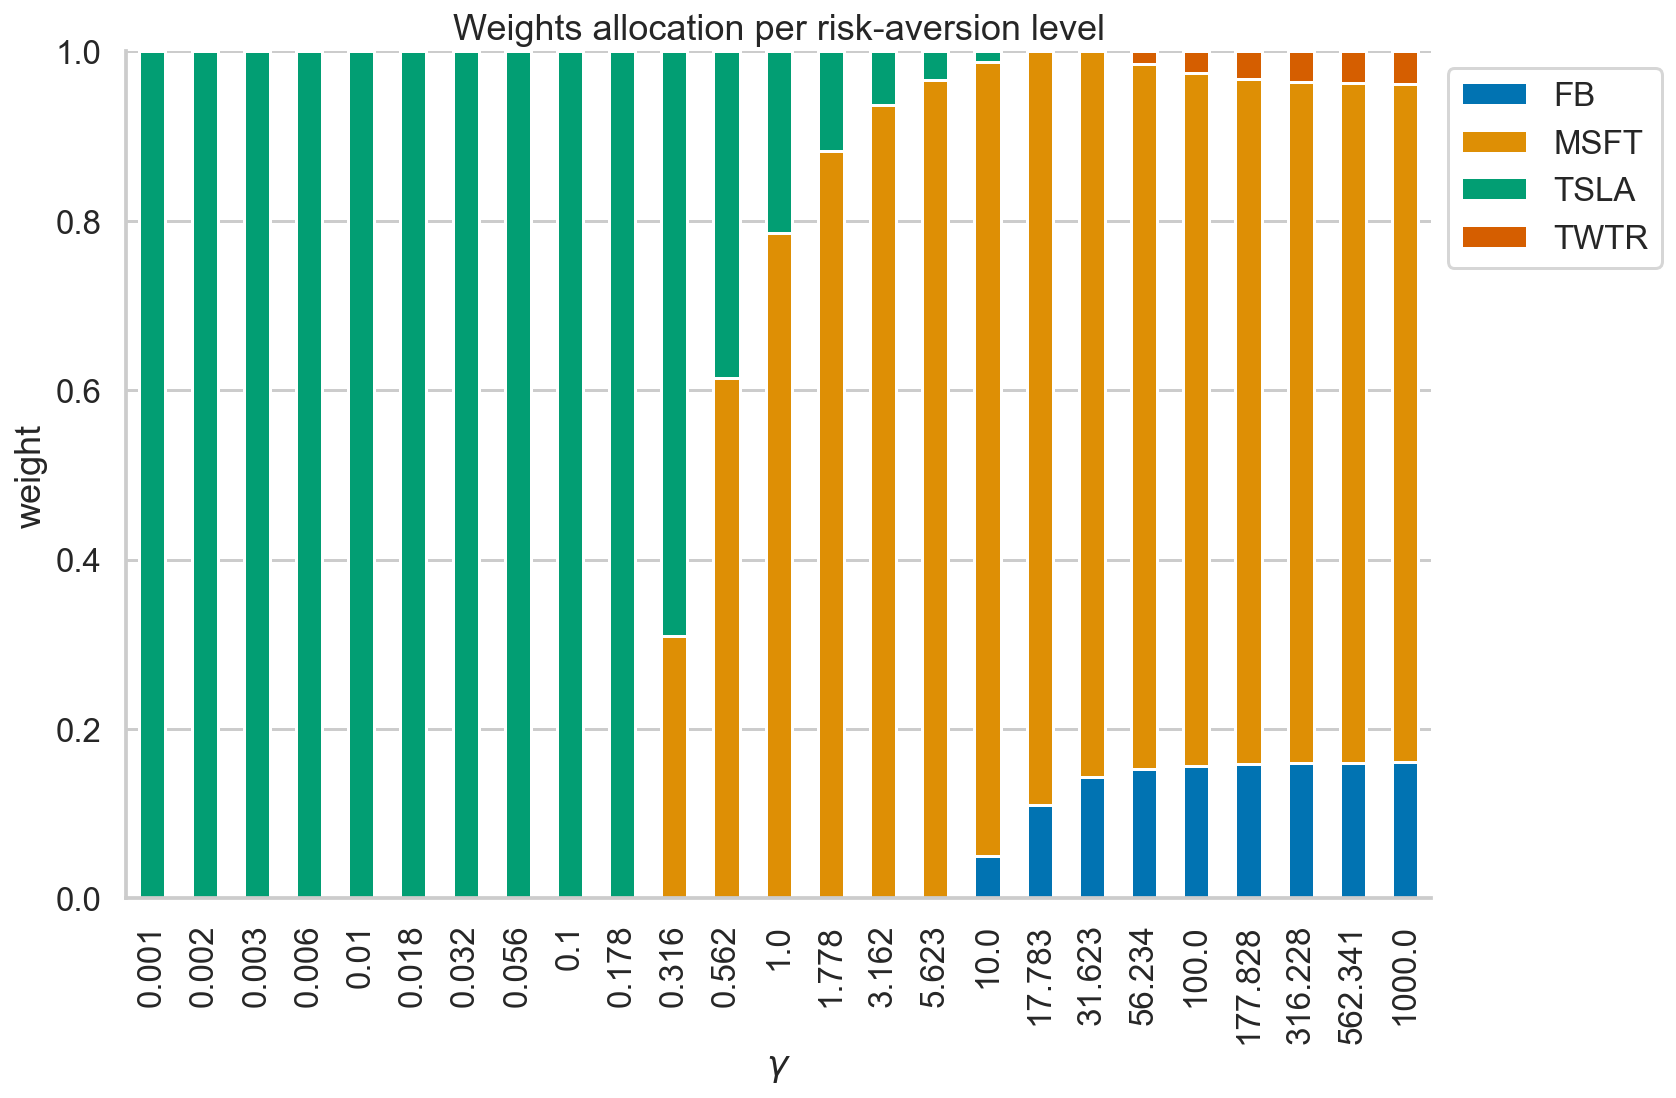

In [31]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=ASSETS, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind="bar", stacked=True) 
ax.set(title="Weights allocation per risk-aversion level",
       xlabel=r"$\gamma$", 
       ylabel="weight")
ax.legend(bbox_to_anchor=(1,1))

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_13", dpi=200)

6. Plot the Efficient Frontier, together with the individual assets:

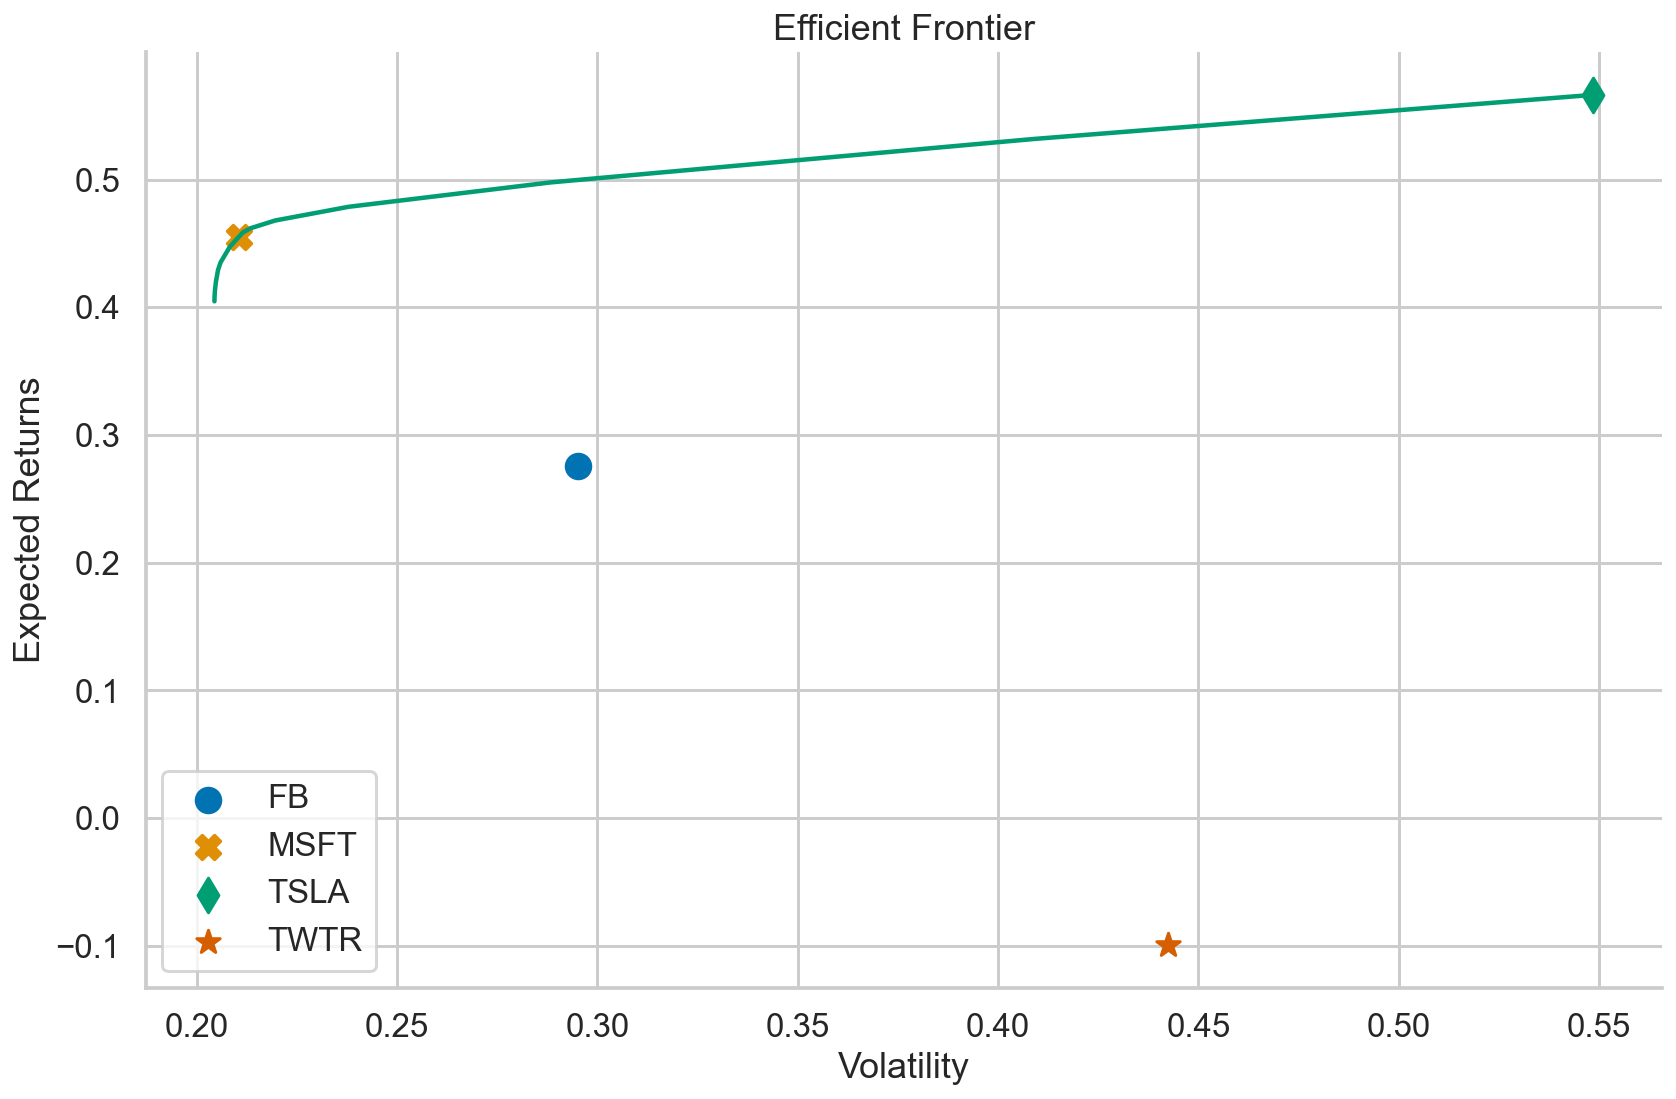

In [32]:
#MARKERS = ["o", "X", "d", "*"]

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-")
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKERS[asset_index], 
                 label=ASSETS[asset_index],
                 s=150)
ax.set(title="Efficient Frontier",
       xlabel="Volatility", 
       ylabel="Expected Returns", )
ax.legend()

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_14", dpi=200)

### There's more

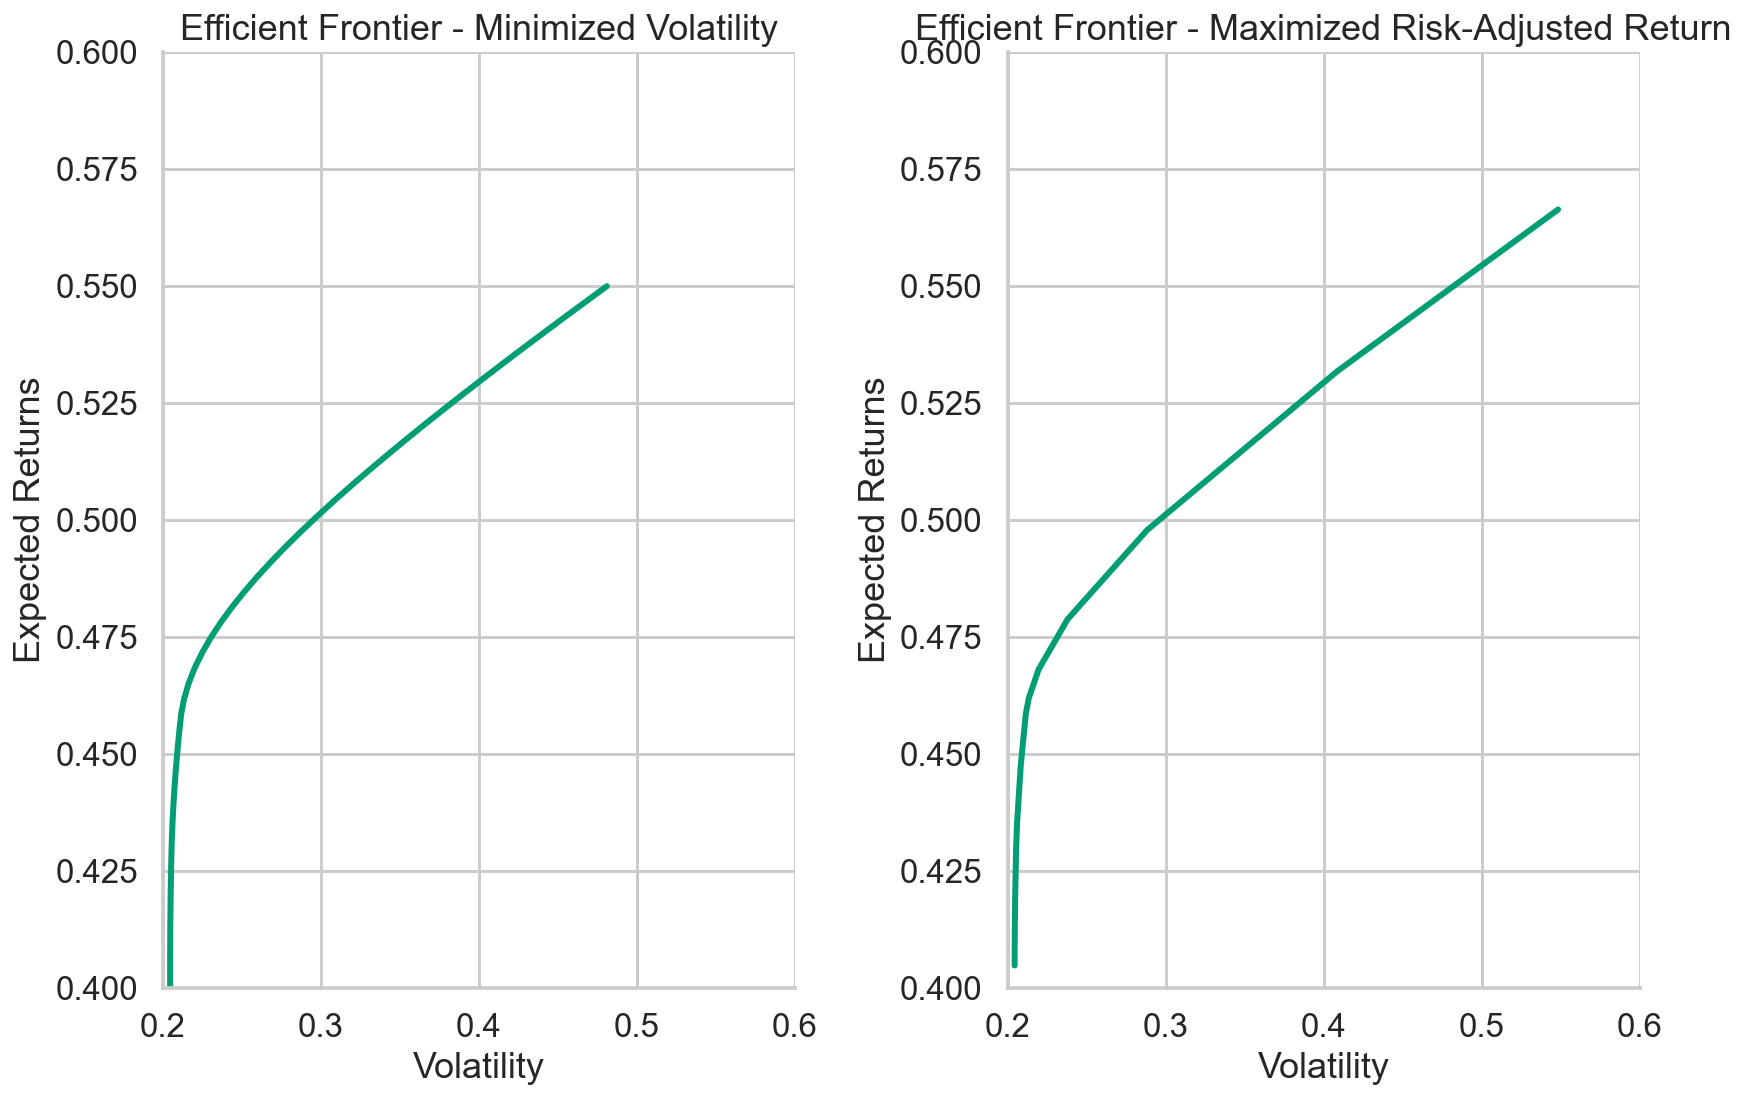

In [33]:
x_lim = [0.2, 0.6]
y_lim = [0.4, 0.6]

fig, ax = plt.subplots(1, 2)
ax[0].plot(vols_range, rtns_range, "g-", linewidth=3)
ax[0].set(title="Efficient Frontier - Minimized Volatility",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

ax[1].plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, "g-", linewidth=3)
ax[1].set(title="Efficient Frontier - Maximized Risk-Adjusted Return",
          xlabel="Volatility", 
          ylabel="Expected Returns",
          xlim=x_lim, 
          ylim=y_lim)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_15", dpi=200)

In [34]:
max_leverage = cp.Parameter()
prob_with_leverage = cp.Problem(objective_function, 
                                [cp.sum(weights) == 1, 
                                cp.norm(weights, 1) <= max_leverage])

In [35]:
LEVERAGE_RANGE = [1, 2, 5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l = np.zeros((N_POINTS, len_leverage))
portf_rtn_l = np.zeros(( N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
    for gamma_ind in range(N_POINTS):
        max_leverage.value = leverage
        gamma_par.value = gamma_range[gamma_ind]
        prob_with_leverage.solve()
        portf_vol_l[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
        portf_rtn_l[gamma_ind, lev_ind] = portf_rtn_cvx.value
        weights_ef[lev_ind, gamma_ind, :] = weights.value
        

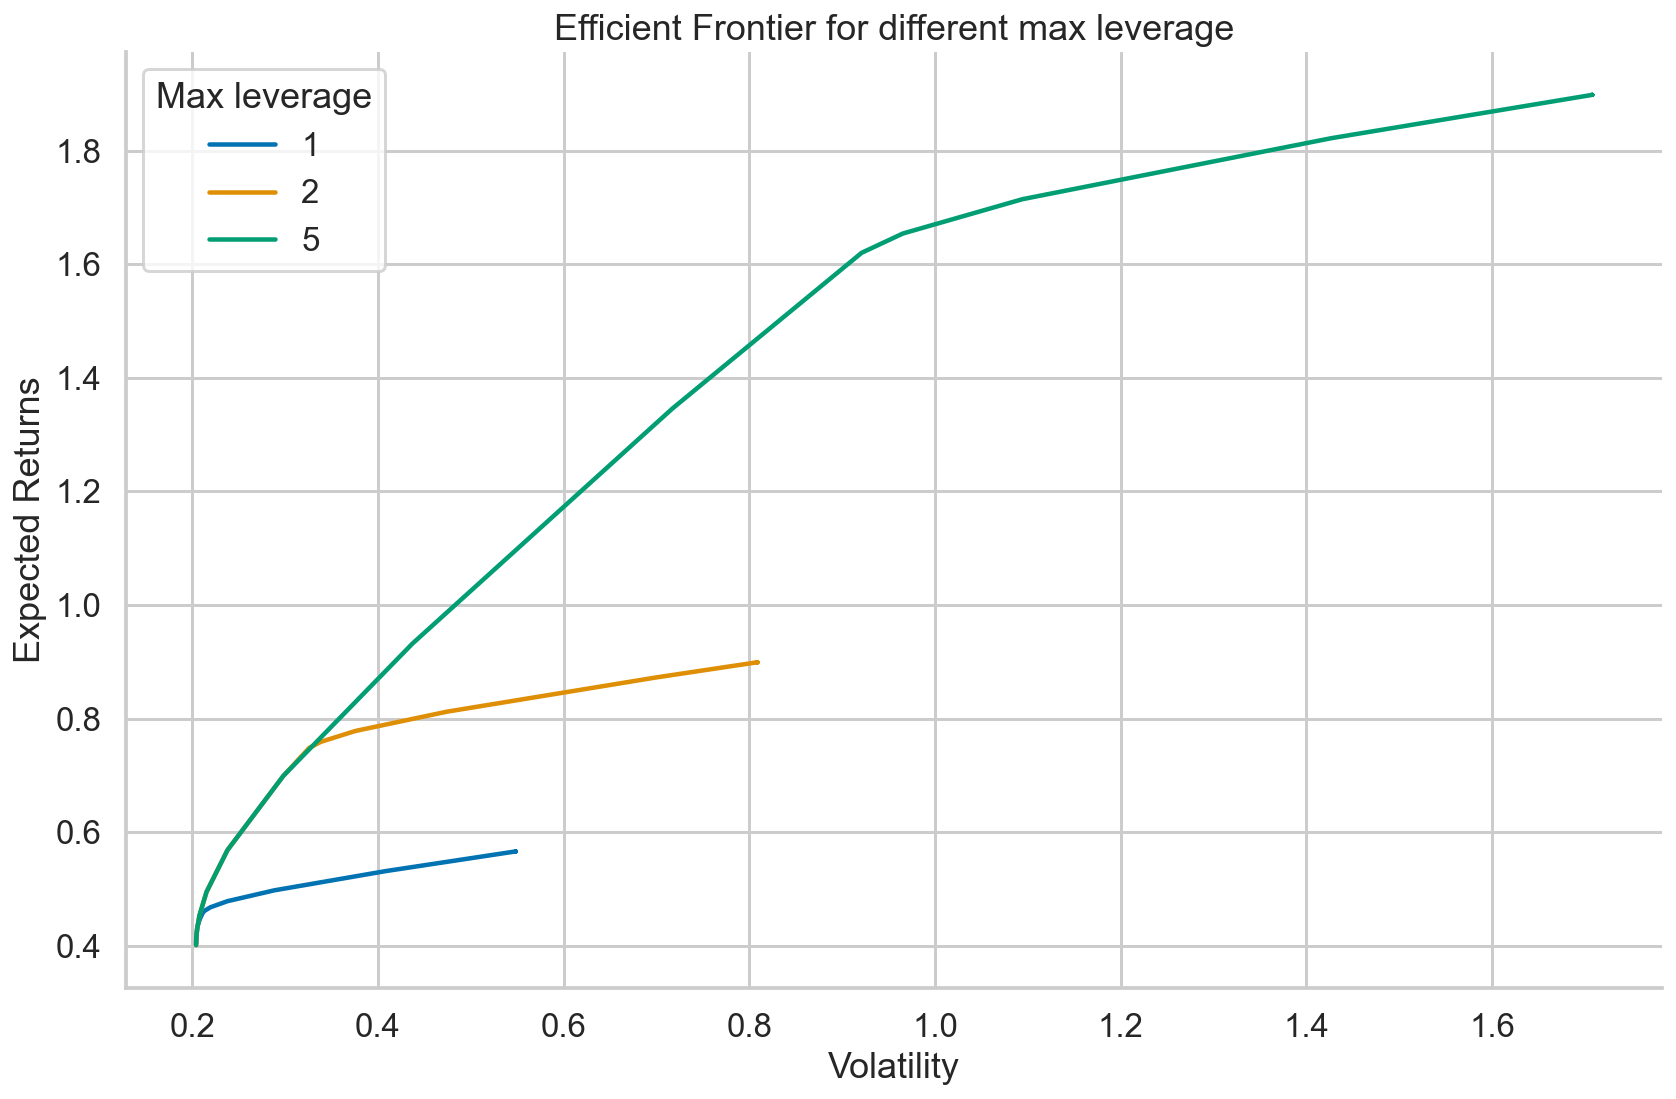

In [36]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
    plt.plot(portf_vol_l[:, leverage_index], 
             portf_rtn_l[:, leverage_index], 
             label=f"{leverage}")

ax.set(title="Efficient Frontier for different max leverage",
       xlabel="Volatility", 
       ylabel="Expected Returns")
ax.legend(title="Max leverage")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_16", dpi=200)

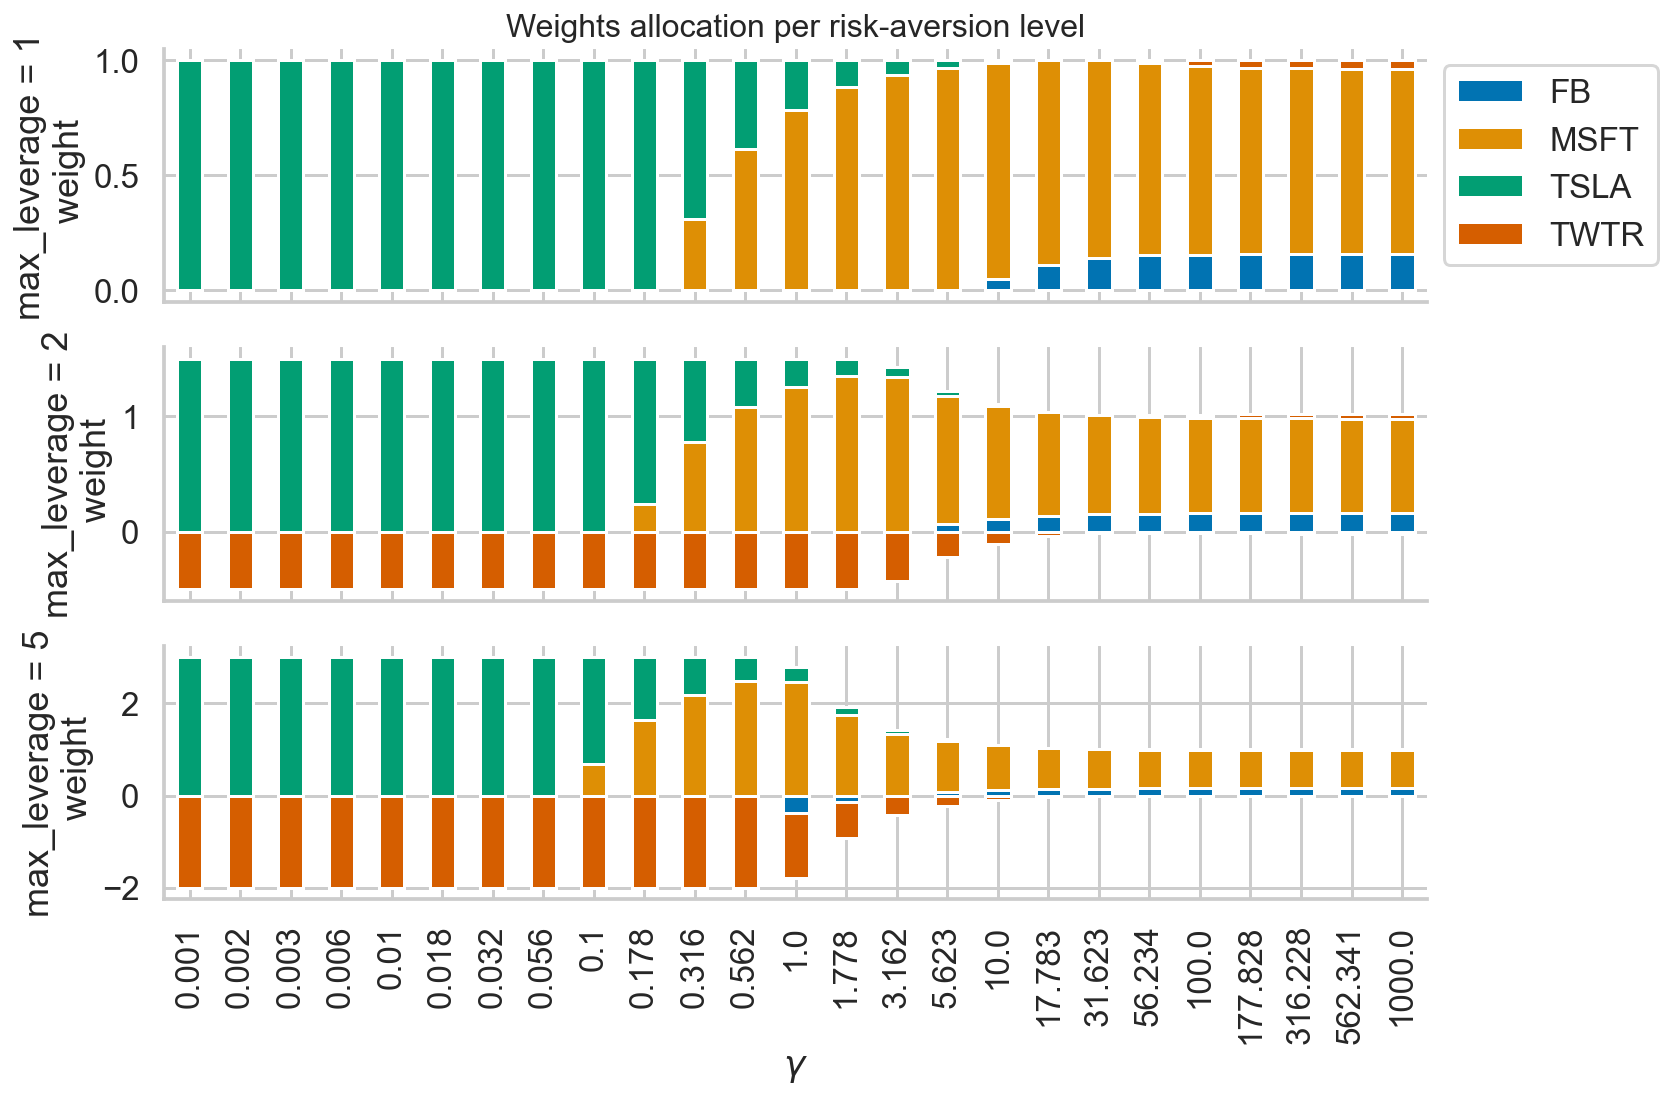

In [37]:
fig, ax = plt.subplots(len_leverage, 1, sharex=True)

for ax_index in range(len_leverage):
    weights_df = pd.DataFrame(weights_ef[ax_index], 
                              columns=ASSETS, 
                              index=np.round(gamma_range, 3))
    weights_df.plot(kind="bar", 
                    stacked=True, 
                    ax=ax[ax_index], 
                    legend=None) 
    ax[ax_index].set(
        ylabel=(f"max_leverage = {LEVERAGE_RANGE[ax_index]}" 
                "\n weight")
    )

    
ax[len_leverage - 1].set(xlabel=r"$\gamma$")
ax[0].legend(bbox_to_anchor=(1,1)) 
ax[0].set_title("Weights allocation per risk-aversion level",
                fontsize=16)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_17", dpi=200)

## 11.5 Finding the optimal portfolio with Hierarchical Risk Parity

### How to do it...

1. Import the libraries:


In [3]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import returns_from_prices
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting


2. Download the stock prices of the 10 biggest US tech companies:

In [4]:
ASSETS = ["AAPL", "MSFT", "AMZN", "GOOG", "FB", 
          "V", "NVDA", "MA", "PYPL", "NFLX"]

prices_df = yf.download(ASSETS, 
                        start="2021-01-01", 
                        end="2021-12-31", 
                        adjusted=True)
prices_df = prices_df["Adj Close"]
prices_df

[*********************100%***********************]  10 of 10 completed


AAPL        AMZN          FB        GOOG          MA  \
Date                                                                     
2020-12-31  131.333542  162.846497  273.160004   87.594002  353.698395   
2021-01-04  128.087067  159.331497  268.940002   86.412003  348.297852   
2021-01-05  129.670700  160.925507  270.970001   87.045998  344.264801   
2021-01-06  125.305794  156.919006  263.309998   86.764503  344.393646   
2021-01-07  129.581635  158.108002  268.739990   89.362503  347.122131   
...                ...         ...         ...         ...         ...   
2021-12-23  175.553543  171.068497  335.239990  147.142502  359.058014   
2021-12-27  179.586868  169.669495  346.179993  148.063995  358.789154   
2021-12-28  178.551132  170.660995  346.220001  146.447998  359.257172   
2021-12-29  178.640778  169.201004  342.940002  146.504501  359.765015   
2021-12-30  177.465637  168.644501  344.359985  146.002502  359.466278   

                  MSFT        NFLX        NVDA        PYPL           V  
Date                                                                    
2020-12-31  219.604492  540.729980  130.386307  234.199997  216.627747  
2021-01-04  214.934357  522.859985  130.970535  231.919998  215.667084  
2021-01-05  215.141708  520.799988  133.879410  234.910004  212.448303  
2021-01-06  209.563217  500.489990  125.986816  226.830002  210.576477  
2021-01-07  215.526764  508.890015  133.272675  235.039993  211.755035  
...                ...         ...         ...         ...         ...  
2021-12-23  333.223267  614.090027  296.286865  192.009995  215.855881  
2021-12-27  340.949280  613.119995  309.331909  192.009995  216.862335  
2021-12-28  339.754517  610.710022  303.104279  190.100006  217.280838  
2021-12-29  340.451477  610.539978  299.895508  189.970001  217.400406  
2021-12-30  337.833008  612.090027  295.747070  191.880005  217.101471  

[252 rows x 10 columns]

3. Calculate the returns from prices:

In [5]:
rtn_df = returns_from_prices(prices_df)

4. Find the optimal allocation using Hierarchical Risk Parity:

In [6]:
hrp = HRPOpt(returns=rtn_df)
hrp.optimize()

OrderedDict([('AAPL', 0.12991684889057412),
             ('AMZN', 0.1560044417909801),
             ('FB', 0.08133848715093475),
             ('GOOG', 0.0853154151598432),
             ('MA', 0.10027749770574462),
             ('MSFT', 0.10829999023848333),
             ('NFLX', 0.10164036813261833),
             ('NVDA', 0.044658614740679864),
             ('PYPL', 0.053263286356470874),
             ('V', 0.13928504983367082)])

5. Display the (cleaned) weights:

In [7]:
weights = hrp.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.12992), ('AMZN', 0.156), ('FB', 0.08134), ('GOOG', 0.08532), ('MA', 0.10028), ('MSFT', 0.1083), ('NFLX', 0.10164), ('NVDA', 0.04466), ('PYPL', 0.05326), ('V', 0.13929)])


We can create a simple pie chart to visualize the optimized portfolio weights:

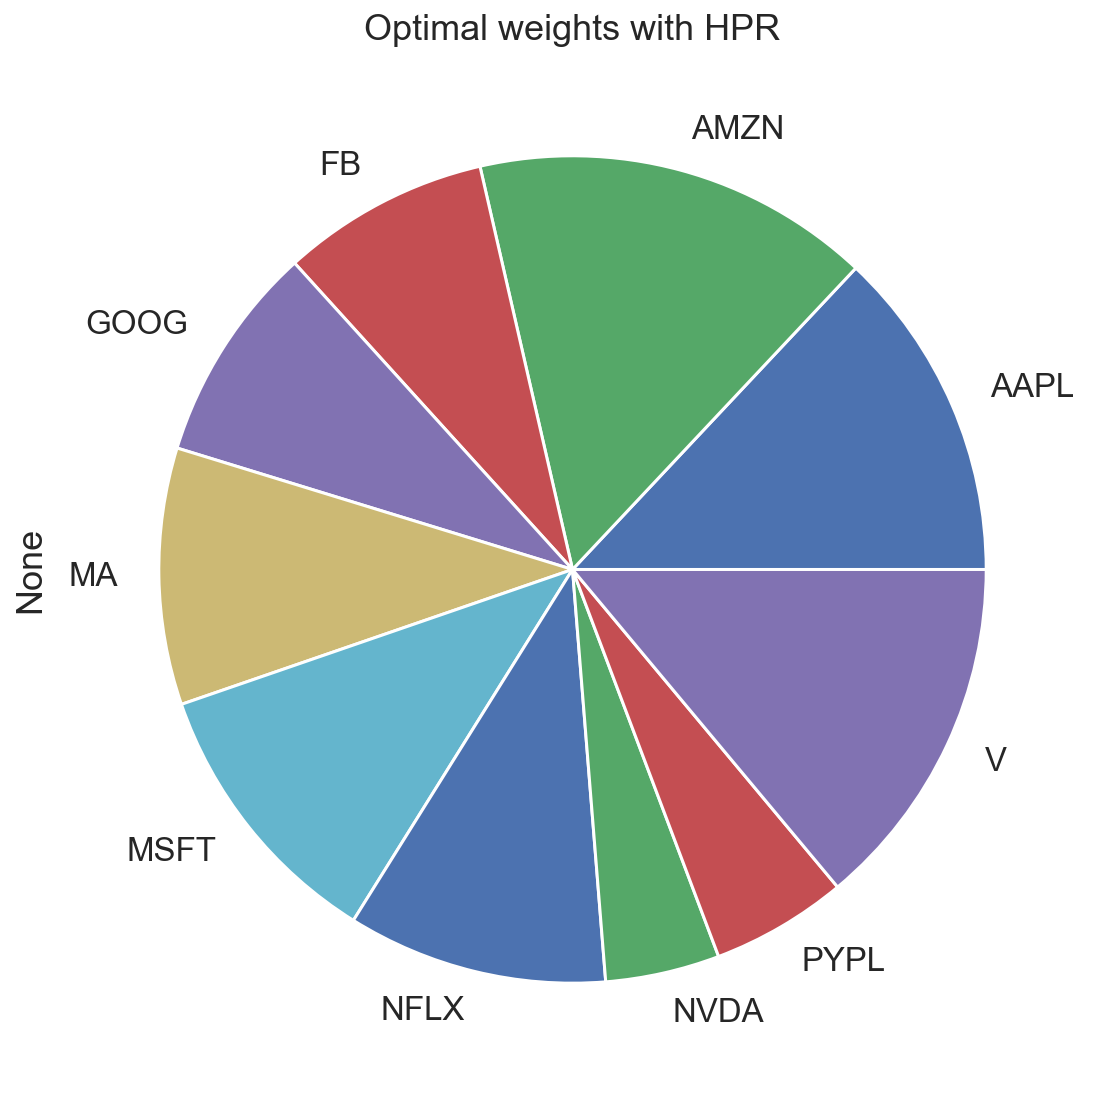

In [8]:
pd.Series(weights).plot(kind="pie",
                        title="Optimal weights with HPR");

sns.despine()
plt.tight_layout()

6. Calculate the portfolio performance:

In [9]:
hrp.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 23.3%
Annual volatility: 19.2%
Sharpe Ratio: 1.21


7. Visualize the hierarchical clustering used for finding the portfolio weights:

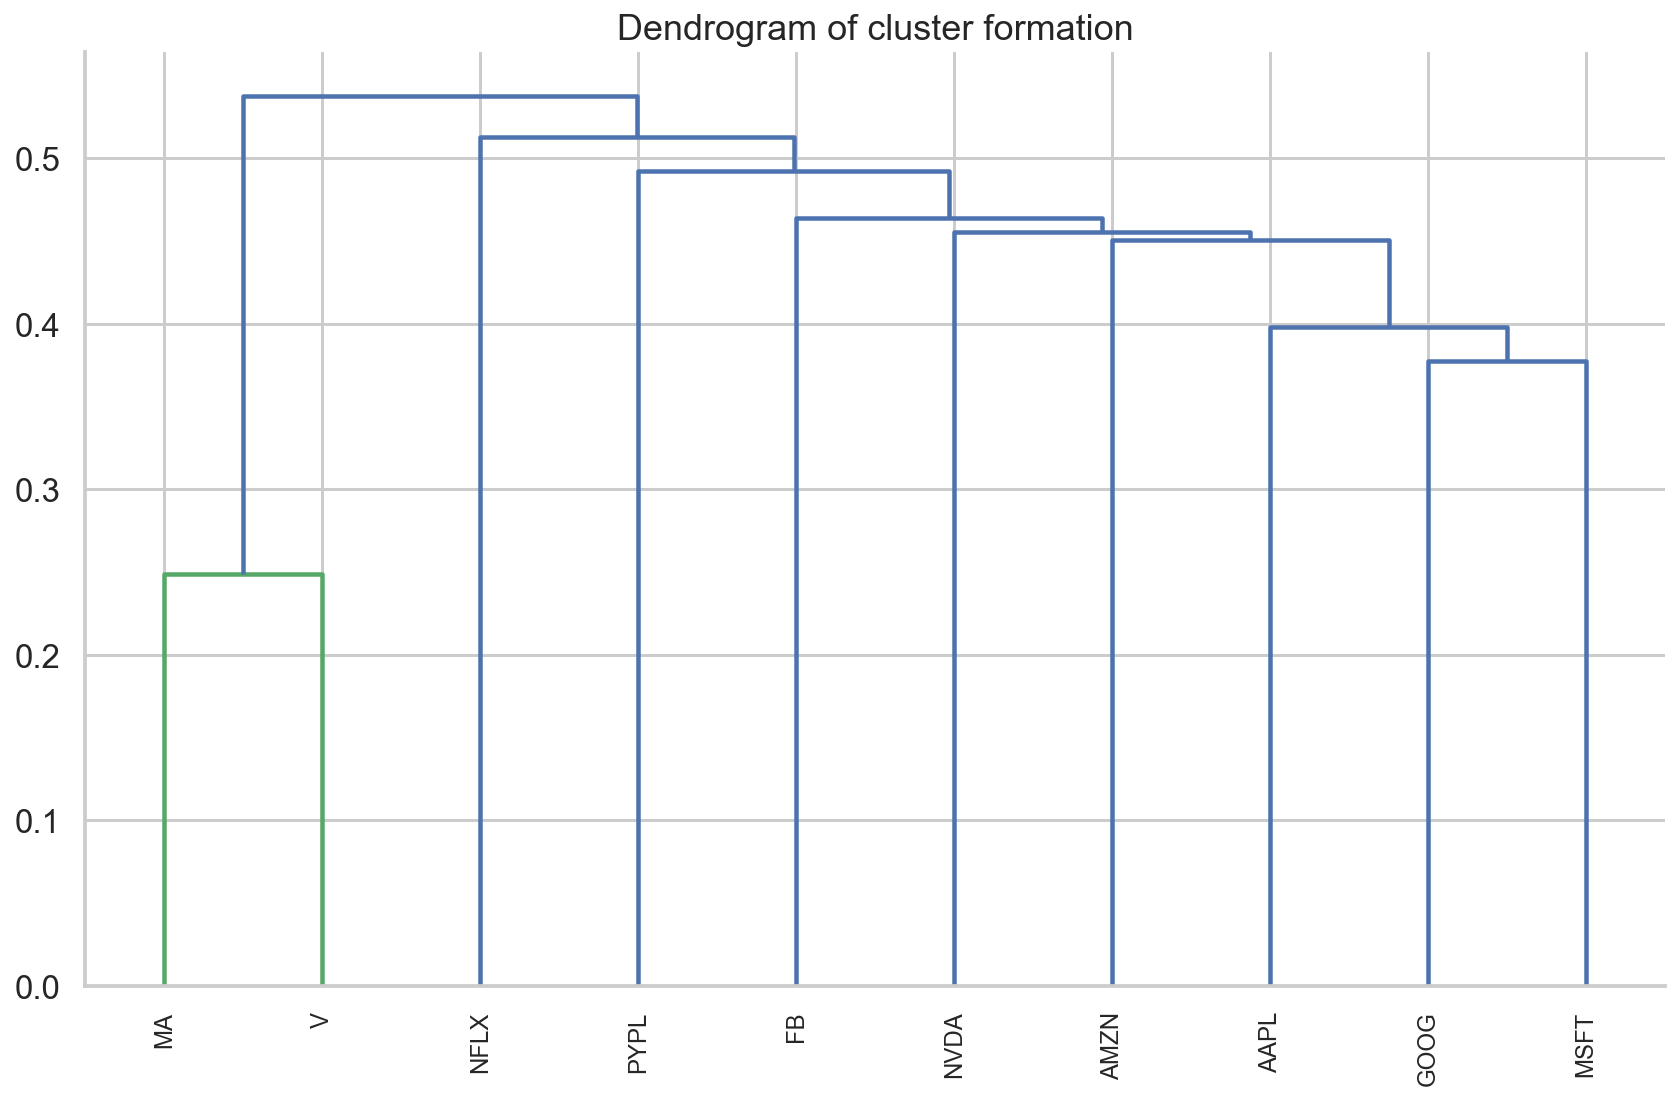

In [10]:
fig, ax = plt.subplots()
plotting.plot_dendrogram(hrp, ax=ax) 
ax.set_title("Dendrogram of cluster formation")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_18", dpi=200)

8. Find the number of stocks to buy using 50,000 USD:

In [24]:
latest_prices = get_latest_prices(prices_df)
allocation_finder = DiscreteAllocation(weights, 
                                       latest_prices, 
                                       total_portfolio_value=50000)
allocation, leftover = allocation_finder.lp_portfolio()
print(allocation)
print(leftover)

{'AAPL': 36, 'AMZN': 2, 'FB': 12, 'GOOG': 2, 'MA': 14, 'MSFT': 16, 'NFLX': 8, 'NVDA': 7, 'PYPL': 14, 'V': 31}
12.54937744140625


In [25]:
# an alternative allocation using the greedy iterative algorithm
allocation, leftover = allocation_finder.greedy_portfolio()
print(allocation)
print(leftover)

{'AMZN': 2, 'V': 32, 'AAPL': 36, 'MSFT': 16, 'NFLX': 8, 'MA': 14, 'GOOG': 2, 'FB': 11, 'PYPL': 14, 'NVDA': 7}
139.39324951171875


### There's more

1. Import the libraries:

In [6]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier

2. Get the expected returns and the covariance matrix:

In [7]:
mu = mean_historical_return(prices_df)
S = CovarianceShrinkage(prices_df).ledoit_wolf()

3. Find and plot the Efficient Frontier:

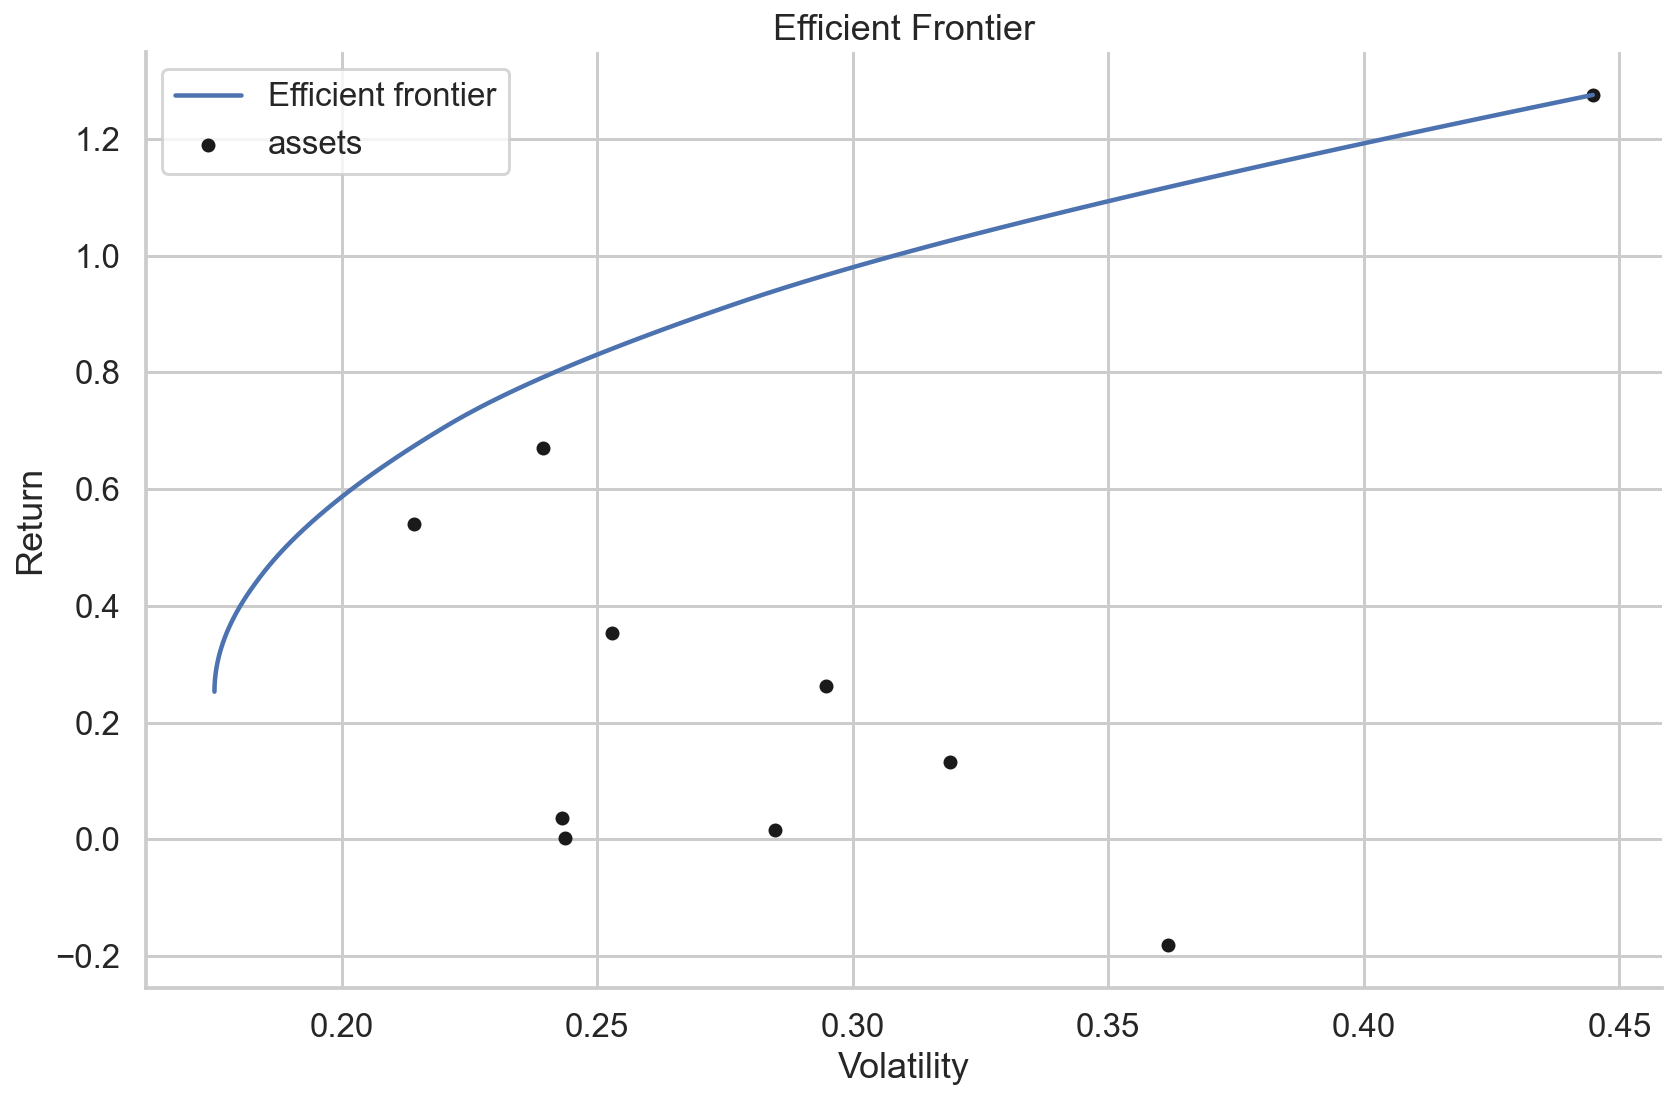

In [9]:
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Efficient Frontier")


sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_11_19", dpi=200)

4. Identify the tangency portfolio:

In [15]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())


OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('FB', 0.0), ('GOOG', 0.55146), ('MA', 0.0), ('MSFT', 0.11808), ('NFLX', 0.0), ('NVDA', 0.33046), ('PYPL', 0.0), ('V', 0.0)])


In [16]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 85.5%
Annual volatility: 25.7%
Sharpe Ratio: 3.32


We get a warning when we are trying to use a different risk-free rate as the one used for finding the tangency portfolio.

In [17]:
ef.portfolio_performance(verbose=True);

Expected annual return: 85.5%
Annual volatility: 25.7%
Sharpe Ratio: 3.32


/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:438: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


5. Add L2 regularization to the portfolio optimization problem:

In [18]:
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.2)

weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.05655), ('AMZN', 0.0), ('FB', 0.0), ('GOOG', 0.29756), ('MA', 0.0), ('MSFT', 0.20673), ('NFLX', 0.0), ('NVDA', 0.43917), ('PYPL', 0.0), ('V', 0.0)])


/opt/homebrew/Caskroom/miniforge/base/envs/pff2/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


6. Find the tangency portfolio with short-selling allowed:

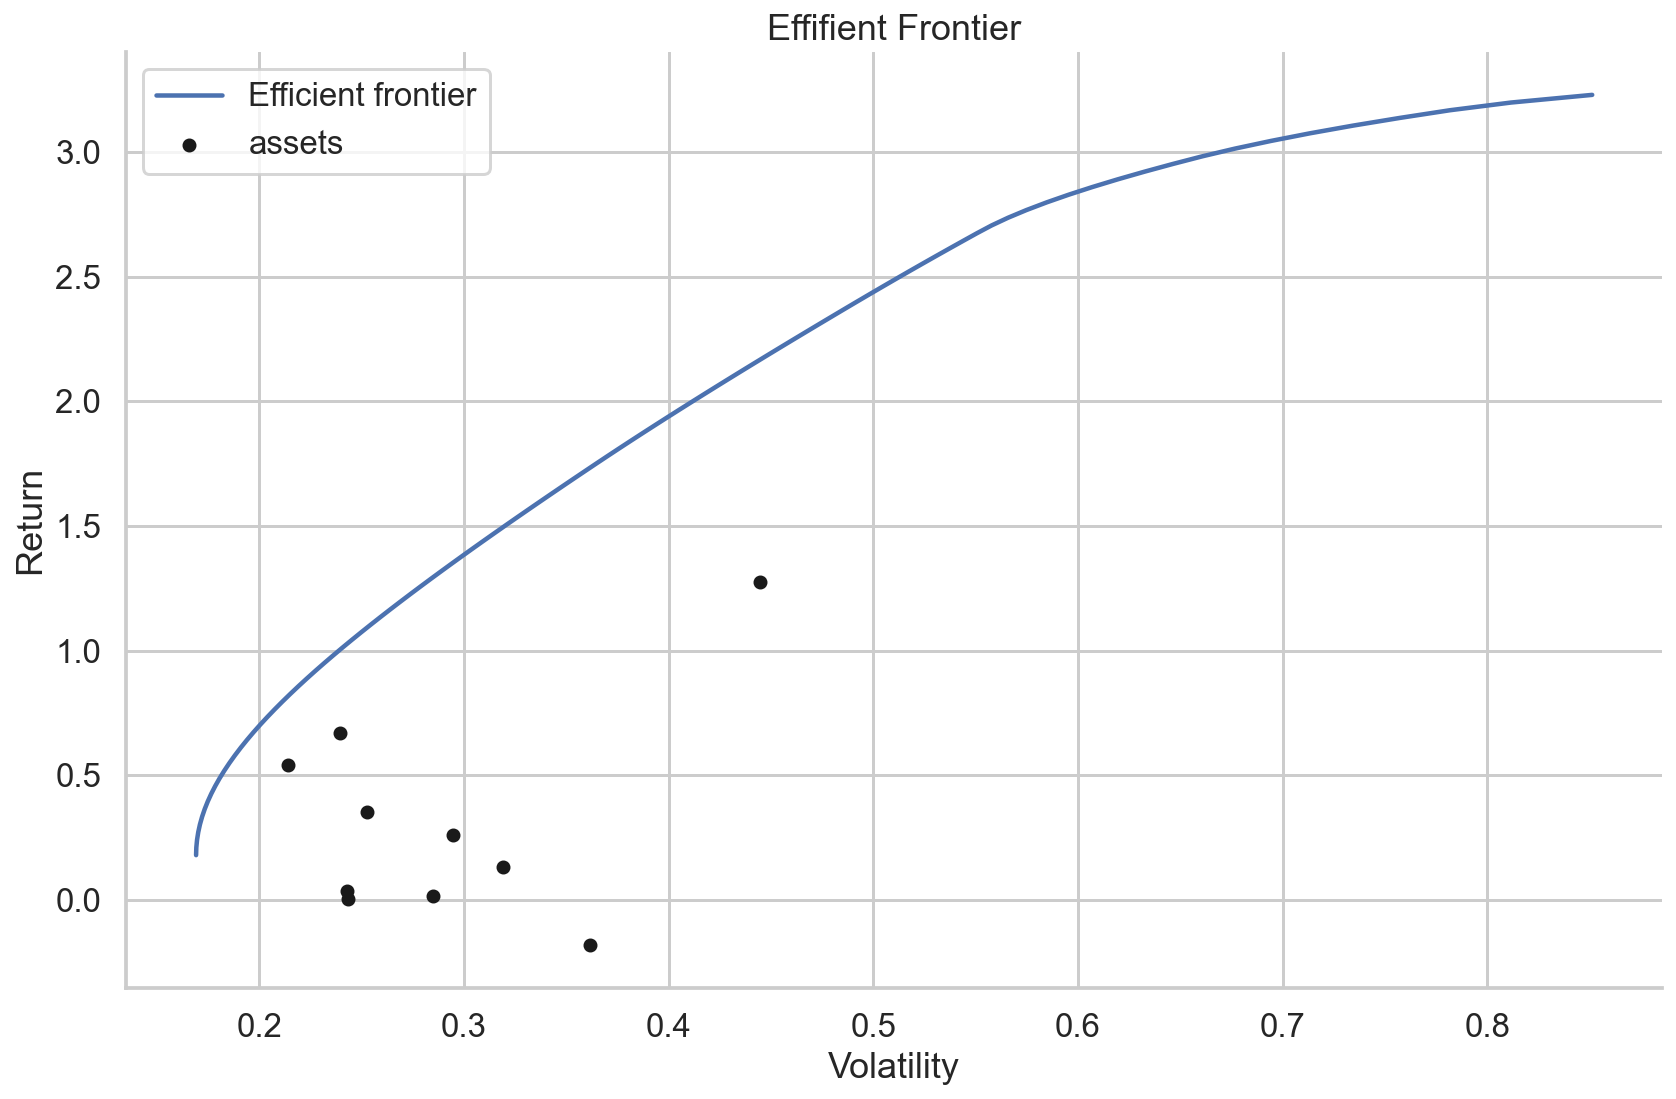

In [19]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.set_title("Effifient Frontier")


sns.despine()
plt.tight_layout()

In [20]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))
weights = ef.max_sharpe(risk_free_rate=0)
print(ef.clean_weights())

OrderedDict([('AAPL', 0.19753), ('AMZN', -0.98181), ('FB', -0.00017), ('GOOG', 1.0), ('MA', -0.07171), ('MSFT', 0.9239), ('NFLX', -0.1608), ('NVDA', 0.80187), ('PYPL', -0.80655), ('V', 0.09775)])


In [21]:
ef.portfolio_performance(verbose=True, risk_free_rate=0);

Expected annual return: 235.2%
Annual volatility: 48.2%
Sharpe Ratio: 4.88
